In [1]:
try:
    import os
    from os import listdir
    from os.path import join
    import pickle
    from queue import Empty, Queue
    from math import exp
    from math import log10
    import torch.nn.functional as F
    from matplotlib import pyplot as plt
    import numpy as np
    from PIL import Image
    import random
    import threading
    from threading import Thread
    import torch
    from torch import nn
    from torch.autograd import Variable
    import torch.optim as optim
    from torch.utils.tensorboard import SummaryWriter
    from torchvision.models.vgg import vgg19
    from tqdm import tqdm
    from libs.SGDR import CosineAnnealingWarmRestarts

except ImportError as e:
    print(e)
    raise ImportError

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

In [4]:
#nn.Sequential(*list(vgg19(pretrained=True).features)[:]).eval()

In [5]:
def find_files(dataset_dir):
    image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir)]
    return image_filenames

In [6]:
data_index_fname = 'data/data_index.p'
data_index_val_fname = 'data/data_index_val.p'

In [7]:
class thread_killer(object):    
    """
    Boolean object for signaling a worker thread to terminate
    """
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [8]:
def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
   
    """
    Threaded worker for pre-processing input data.
    tokill is a thread_killer object that indicates whether a thread should be terminated
    dataset_generator is the training/validation dataset generator
    batches_queue is a limited size thread-safe Queue instance.
    """
    while tokill() == False:
        for batch, (batch_images, batch_targets) in enumerate(dataset_generator):
            #We fill the queue with new fetched batch until we reach the max size.
            batches_queue.put((batch, (batch_images, batch_targets)), block=True)
            if tokill() == True:
                return

In [9]:
def threaded_cuda_batches(tokill,cuda_batches_queue,batches_queue):
    
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue is the queue that fetches numpy cpu tensors.
    cuda_batches_queue receives numpy cpu tensors and transfers them to GPU space.
    """
    while tokill() == False:
        batch, (batch_images, batch_targets) = batches_queue.get(block=True)
        
        batch_images = torch.from_numpy(batch_images)
        batch_labels = torch.from_numpy(batch_targets)
        
        batch_images = Variable(batch_images).cuda()
        batch_labels = Variable(batch_labels).cuda()
        
        cuda_batches_queue.put((batch, (batch_images, batch_labels)), block=True)
        if tokill() == True:
            return

In [10]:
class threadsafe_iter:
    
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

In [11]:
def get_path_i(paths_count):
    
    """
    Cyclic generator of paths indices
    """   
    current_path_id = 0
    while True:
        yield current_path_id
        current_path_id  = (current_path_id + 1) % paths_count

In [12]:
class InputGenerator:
    def __init__(self, data_index_fname, batch_size, debug=False):
        print('loading files index...')
        with open(data_index_fname, 'rb') as f:
            data_dicts = pickle.load(f)
            
        lores_datafiles = [f for f in find_files('data/LoRes/Arrays/FIELD/')]
        lores_datafiles.sort()
        hires_datafiles = [f for f in find_files('data/HiRes/Arrays/FIELD/')]
        hires_datafiles.sort()
        
        data_dict_lores = dict(zip(lores_datafiles, [np.load(f, mmap_mode = 'r') for f in lores_datafiles]))
        data_dict_hires = dict(zip(hires_datafiles, [np.load(f, mmap_mode = 'r') for f in hires_datafiles]))
        
        self.data_index_fname = data_index_fname
        self.batch_size = batch_size
        self.debug = debug
        self.index = 0
        self.init_count = 0
        self.dicts = data_dicts
        self.dict_lores = data_dict_lores
        self.dict_hires = data_dict_hires
        print('examples number: %d' % len(self.dicts))

        self.lock = threading.Lock()  # mutex for input path
        self.yield_lock = threading.Lock()  # mutex for generator yielding of batch
        self.path_id_generator = threadsafe_iter(get_path_i(len(self.dicts)))
        self.imgs = []
        self.trgs = []      

    #def preprocess_img(self, fn):
    #    img = None
    #    if self.args.memcache:
    #        if fn in self.images_cached:
    #            img = self.images_cached[fn]
    #    if img is None:
    #        img = cv2.imread(fn)
    #        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #        if self.args.memcache:
    #            self.images_cached[fn] = img
     #   return img

    def shuffle(self):
        random.shuffle(self.dicts)

    def __iter__(self):
        while True:
            # In the start of each epoch we shuffle the data paths
            with self.lock:
                if (self.init_count == 0):
                    self.shuffle()
                    self.imgs, self.trgs = [], []
                    self.init_count = 1
            # Iterates through the input paths in a thread-safe manner
            for path_id in self.path_id_generator:
                img_fn = self.dicts[path_id]["data_fname_lores"]
                img_id = self.dicts[path_id]["data_lores_idx"]
                img = self.dict_lores[img_fn][img_id]
                
                trg_fn = self.dicts[path_id]["data_fname_hires"]
                trg_id = self.dicts[path_id]["data_hires_idx"]
                trg = self.dict_hires[trg_fn][trg_id]

                #img = self.preprocess_img(img_fn)
                #trg = self.targets_transformer(trgs)
                #trg = trg.astype(np.float32)

                # Concurrent access by multiple threads to the lists below
                with self.yield_lock:
                    if (len(self.imgs)) < self.batch_size:
                        self.imgs.append(img)
                        self.trgs.append(trg)
                    if len(self.imgs) % self.batch_size == 0:
                        imgs_f32 = np.float32(self.imgs)
                        trgs_f32 = np.float32(self.trgs)
                        yield (imgs_f32, trgs_f32)
                        self.imgs, self.trgs = [], []
            # At the end of an epoch we re-init data-structures
            with self.lock:
                random.shuffle(self.dicts)
                self.init_count = 0

    def __call__(self):
        return self.__iter__()

# SSIM

In [13]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

In [14]:
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    #.mm - Performs a matrix multiplication of the matrice
    
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

In [15]:
def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

In [16]:
def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

# LOSS

In [17]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        #vgg = vgg19(pretrained=True)
        #vgg = vgg.cuda()
        #loss_network = nn.Sequential(*list(vgg.features)[:20]).eval()
        # A sequential container. Modules will be added to it in the order they are passed in the constructor. 
        # Alternatively, an ordered dict of modules can also be passed in.
        #for param in loss_network.parameters():
        #    param.requires_grad = False
        #self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()

    def forward(self, fake_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - fake_labels)
        
        # Perception Loss
        #perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        
        #generator_loss = image_loss + 0.005 * adversarial_loss + 0.01 * perception_loss
        generator_loss = image_loss + 0.005 * adversarial_loss
        return generator_loss

In [18]:
#class DiscriminatorLoss(nn.Module):
    #def __init__(self):
    #    super(DiscriminatorLoss, self).__init__()

    #def forward(self, fake_labels, real_labels):
    #    discriminator_loss = 1 - real_labels + fake_labels
    #    return discriminator_loss

In [19]:
g_loss = GeneratorLoss()
#d_loss = DiscriminatorLoss()

In [20]:
# MODEL

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),nn.PReLU())
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),nn.BatchNorm2d(64))
        self.block8 = UpsampleBLock(64, 5)
        self.block9 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        block9 = self.block9(block8)

        return (torch.tanh(block9) + 1) / 2

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [23]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        
        # Rearranges elements in a tensor of shape (∗,C×r^2,H,W) 
        # to a tensor of shape (*, C, H x r, W x r).
        # This is useful for implementing efficient sub-pixel convolution with a stride of 1/r
        
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

# TRAIN

In [25]:
#netG = Generator()
#print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

In [26]:
#netD = Discriminator()
#print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

In [27]:
def train_epoch(netG: nn.Module, netD: nn.Module, optimizerG: torch.optim.Optimizer, optimizerD: torch.optim.Optimizer, 
                epoch: int, NUM_EPOCHS: int, cuda_batches_queue: Queue,
                generator_criterion: callable, 
                #discriminator_criterion: callable,
                STEPS_PER_EPOCH: int, batch_size: int, crop_size: int):
    
    netG.train()
    netD.train()
    term_columns = os.get_terminal_size().columns
    pbar = tqdm(total=STEPS_PER_EPOCH, ncols=min(term_columns,180))
    
    mse_metrics = 0.0
    ssim_metrics = 0.0
    psnr_metrics = 0.0
    batch_sizes = 0
    running_results_g_loss = 0.0
    running_results_d_loss = 0.0
    ssims = 0
    
    for batch_idx in range(STEPS_PER_EPOCH):
        _, (img, trg) = cuda_batches_queue.get(block=True)
        
        batch_sizes += batch_size
        
        img[:,0,:,:] = (img[:,0,:,:]+40)/80
        img[:,1,:,:] = (img[:,1,:,:]+40)/80
        img[:,2,:,:] = (img[:,2,:,:]-940)/120
        
        trg[:,0,:,:] = (trg[:,0,:,:]+40)/80
        trg[:,1,:,:] = (trg[:,1,:,:]+40)/80       
        trg[:,2,:,:] = (trg[:,2,:,:]-940)/120
        
        sub_patch_w = random.randrange(0, 110 - crop_size)
        sub_patch_h = random.randrange(0, 110 - crop_size)
        
        img = img[:,:,sub_patch_w:sub_patch_w+crop_size,sub_patch_h:sub_patch_h+crop_size]
        trg = trg[:,:,5*sub_patch_w:5*(sub_patch_w+crop_size),5*sub_patch_h:5*(sub_patch_h+crop_size)]
        
        g_update_first = True

        fake_img = netG(img)
        fake_out = netD(fake_img).mean()
        g_loss = generator_criterion(fake_out, fake_img, trg)
        
        netG.zero_grad()
        g_loss.backward(retain_graph = True)
        optimizerG.step()     
    
        real_out = netD(trg).mean()
        fake_out = netD(fake_img.detach()).mean()
        d_loss = 1 - real_out + fake_out

        netD.zero_grad()
        d_loss.backward()
        optimizerD.step()
        
        running_results_g_loss += g_loss.item() * batch_size
        running_results_d_loss += d_loss.item() * batch_size
        
        batch_mse = ((fake_img - trg) ** 2).data.mean()
        mse_metrics += batch_mse * batch_size
        batch_ssim = ssim(fake_img, trg).item()
        ssims += batch_ssim * batch_size
        psnr_metrics = 10 * log10((trg.max()**2) / (mse_metrics / batch_sizes))
        ssim_metrics = ssims / batch_sizes
        
        pbar.update(1)
        pbar.set_postfix_str('Train Epoch: %d [%d/%d (%.2f%%)]\tG_Loss: %.6f; D_Loss: %.6f; MSE: %.6f; SSIM: %.6f; PSNR: %.6f' % (epoch,
                                                                                                                                 batch_idx+1,
                                                                                                                                 STEPS_PER_EPOCH,
                                                                                                                                 100. *(batch_idx+1) / STEPS_PER_EPOCH,
                                                                                                                                 running_results_g_loss/batch_sizes,
                                                                                                                                 running_results_d_loss/batch_sizes,
                                                                                                                                 mse_metrics,
                                                                                                                                 ssim_metrics,
                                                                                                                                 psnr_metrics))
        if batch_idx >= STEPS_PER_EPOCH-1:
            break
            
    g_loss = running_results_g_loss/batch_sizes
    d_loss = running_results_d_loss/batch_sizes
    
    #ssim_metrics = float(((ssim_metrics / STEPS_PER_EPOCH)))
    #psnr_metrics = float(((psnr_metrics / STEPS_PER_EPOCH)))
    mse_metrics = float(mse_metrics.cpu())
    
    pbar.set_postfix_str('Train Epoch: %d; G_Loss: %.6f; D_Loss: %.6f; MSE: %.6f; SSIM: %.6f; PSNR: %.6f' % (epoch,
                                                                                                             g_loss,
                                                                                                             d_loss,
                                                                                                             mse_metrics,
                                                                                                             ssim_metrics,
                                                                                                             psnr_metrics))
 #   for tag, param in model.named_parameters():
#        TBwriter.add_histogram('grad/%s'%tag, param.grad.data.cpu().numpy(), epoch)
 #       TBwriter.add_histogram('weight/%s' % tag, param.data.cpu().numpy(), epoch)

    # if (args.debug & (epoch % 10 == 0)):
    #     TBwriter.add_images('input', img, epoch)

#    if args.debug:
#        for mname in activations.keys():
#            TBwriter.add_histogram('activations/%s' % mname, activations[mname], epoch)

    pbar.close()

    losses_dict = {'train_g_loss': g_loss,
                   'train_d_loss': d_loss}
    metrics_values = {'MSE': mse_metrics,
                     'PSNR': psnr_metrics,
                     'SSIM': ssim_metrics}
    return dict(**losses_dict, **metrics_values)

In [28]:
def validation(netG: nn.Module, netD: nn.Module, cuda_batches_queue: Queue, generator_criterion: callable,
               VAL_STEPS: int, epoch: int, val_batch_size: int):
    
    netG.eval()
    netD.eval()
    
    mse_metrics = 0.0
    ssim_metrics = 0.0
    psnr_metrics = 0.0
    batch_sizes = 0
    running_results_g_loss = 0.0
    running_results_d_loss = 0.0
    ssims = 0
    
    with torch.no_grad():
        term_columns = os.get_terminal_size().columns
        pbar = tqdm(total=VAL_STEPS, ncols=min(term_columns, 180))
        for batch_idx in range(VAL_STEPS):
            _, (img, trg) = cuda_batches_queue.get(block=True)
            
            batch_sizes += val_batch_size

            img[:,0,:,:] = (img[:,0,:,:]+40)/80
            img[:,1,:,:] = (img[:,1,:,:]+40)/80
            img[:,2,:,:] = (img[:,2,:,:]-940)/120
            
            trg[:,0,:,:] = (trg[:,0,:,:]+40)/80
            trg[:,1,:,:] = (trg[:,1,:,:]+40)/80       
            trg[:,2,:,:] = (trg[:,2,:,:]-940)/120

            output = netG(img)
            fake_out = netD(output).mean()
            g_loss = generator_criterion(fake_out, output, trg)
            real_out = netD(trg).mean()
            d_loss = 1 - real_out + fake_out

            running_results_g_loss += g_loss.item() * val_batch_size
            running_results_d_loss += d_loss.item() * val_batch_size
            
            batch_mse = ((output - trg) ** 2).data.mean()
            mse_metrics += batch_mse * val_batch_size
            batch_ssim = ssim(output, trg).item()
            ssims += batch_ssim * val_batch_size
            psnr_metrics = 10 * log10((trg.max()**2) / (mse_metrics / batch_sizes))
            ssim_metrics = ssims / batch_sizes
            mse_metrics = float(mse_metrics.cpu())
        
            pbar.update(1)
            if batch_idx >= VAL_STEPS-1:
                break
        pbar.close()

    g_loss = running_results_g_loss/batch_sizes
    d_loss = running_results_d_loss/batch_sizes

    losses_dict = {'val_g_loss': g_loss,
                   'val_d_loss': d_loss}
    metrics_values = {'MSE': mse_metrics,
                     'PSNR': psnr_metrics,
                     'SSIM': ssim_metrics}
    return dict(**losses_dict, **metrics_values)

Set the learning rate of each parameter group using a cosine annealing schedule, where $\eta_{max}$ is set to the initial lr, $T_{cur}$ is the number of epochs since the last restart and $T_{i}$ is the number of epochs between two warm restarts in SGDR:

$$
        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 +
        \cos\left(\frac{T_{cur}}{T_{i}}\pi\right)\right)
$$

When $T_{cur}=T_{i}$, set $\eta_t = \eta_{min}$.

When $T_{cur}=0$ after restart, set $\eta_t=\eta_{max}$.

It has been proposed in  `SGDR: Stochastic Gradient Descent with Warm Restarts`_.

Args:

optimizer (Optimizer): Wrapped optimizer.
        
T_0 (int): Number of iterations for the first restart.
        
T_mult (int, optional): A factor increases $T_{i}$ after a restart. Default: 1.
        
eta_min (float, optional): Minimum learning rate. Default: 0.

last_epoch (int, optional): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

In [29]:
def main(start_epoch: int,
         NUM_EPOCHS: int, STEPS_PER_EPOCH: int, batch_size: int,
         VAL_STEPS: int, val_batch_size: int, crop_size: int):
    
    torch.autograd.set_detect_anomaly(True)
   # resume_state = None
   # if 'resume' in args:
        # restore epoch and other parameters
   #     with open(os.path.join('./', 'scripts_backup', args.resume, 'launch_parameters.txt'), 'r') as f:
   #         args_resume = f.readlines()[1:]
   #         args_resume = [t.replace('\n', '') for t in args_resume]
   #         args_resume = parse_args(args_resume)
   #         for k in [k for k in args_resume.__dict__.keys()]:
   #             if k in ['run_name', 'snapshot', 'resume', 'lr']:
    #                continue
                # if k in args.__dict__.keys():
                #     continue
    #            args.__dict__[k] = getattr(args_resume, k)

    #    resume_state = SimpleNamespace()
    #    resume_state.dates_train = np.load(os.path.join('./', 'scripts_backup', args.resume, 'dates_train.npy'), allow_pickle=True)
    #    resume_state.dates_val = np.load(os.path.join('./', 'scripts_backup', args.resume, 'dates_val.npy'), allow_pickle=True)
    #    resume_state.epoch_snapshot = find_files(os.path.join('./logs', args.resume), 'ep????.pth.tar')[0]
    #    resume_state.epoch = int(os.path.basename(resume_state.epoch_snapshot).replace('.pth.tar', '').replace('ep', ''))
    #    resume_state.lr = args.lr


    #region args parsing
    #curr_run_name = args.run_name
    #endregion

    #region preparations
    #base_logs_dir = os.path.join('./logs', curr_run_name)
    #try:
    #    EnsureDirectoryExists(base_logs_dir)
    #except:
    #    print(f'logs directory couldn`t be found and couldn`t be created:\n{base_logs_dir}')
    #    raise FileNotFoundError(f'logs directory couldn`t be found and couldn`t be created:\n{base_logs_dir}')

    #scripts_backup_dir = os.path.join('./scripts_backup', curr_run_name)
    #try:
    #    EnsureDirectoryExists(scripts_backup_dir)
    #except:
    #    print(f'backup directory couldn`t be found and couldn`t be created:\n{scripts_backup_dir}')
    #    raise FileNotFoundError(f'backup directory couldn`t be found and couldn`t be created:\n{scripts_backup_dir}')

    #tboard_dir_train = os.path.join(os.path.abspath('./'), 'logs', curr_run_name, 'TBoard', 'train')
    #tboard_dir_val = os.path.join(os.path.abspath('./'), 'logs', curr_run_name, 'TBoard', 'val')
    #try:
    #    EnsureDirectoryExists(tboard_dir_train)
    #except:
    #    print('Tensorboard directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_train)
    #    raise FileNotFoundError(
    #        'Tensorboard directory directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_train)
    #try:
    #    EnsureDirectoryExists(tboard_dir_val)
    #except:
    #    print('Tensorboard directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_val)
    #    raise FileNotFoundError(
    #        'Tensorboard directory directory couldn`t be found and couldn`t be created:\n%s' % tboard_dir_val)
    #endregion

    # region backing up the scripts configuration
    #print('backing up the scripts')
    #ignore_func = lambda dir, files: [f for f in files if (isfile(join(dir, f)) and f[-3:] != '.py')] + [d for d in files if ((isdir(d)) & (('srcdata' in d) |
                                                                                                                                            #('scripts_backup' in d) |
                                                                                                                                           # ('__pycache__' in d) |
                                                                                                                                            #('.pytest_cache' in d) |
                                                                                                                                            #d.endswith('.ipynb_checkpoints') |
                                                                                                                                           # d.endswith('logs.bak') |
                                                                                                                                           # d.endswith('outputs') |
                                                                                                                                           # d.endswith('processed_data') |
                                                                                                                                           # d.endswith('build') |
                                                                                                                                           # d.endswith('logs') |
                                                                                                                                           # d.endswith('snapshots')))]
    #copytree_multi('./',
    #               './scripts_backup/%s/' % curr_run_name,
    #               ignore=ignore_func)

    #with open(os.path.join(scripts_backup_dir, 'launch_parameters.txt'), 'w+') as f:
    #    f.writelines([f'{s}\n' for s in sys.argv])
    # endregion backing up the scripts configuration

    cuda = True if torch.cuda.is_available() else False
    if cuda:
        torch.cuda.set_device(0)
    cuda_dev = torch.device('cuda:0')

    print('creating the model')
    
    #if args.pnet:
    #    model = SIAmodel_PyramidNet(args, classes_num=9)
    #else:
    #    model = SIAmodel(args, classes_num=9)
    #if resume_state is not None:
    #    model.load_state_dict(torch.load(resume_state.epoch_snapshot))

    #TB_writer_train = SummaryWriter(log_dir=tboard_dir_train)
    #TB_writer_val = SummaryWriter(log_dir=tboard_dir_val)

    netG = Generator()
    netG = netG.cuda()
    
    netD = Discriminator()
    netD = netD.cuda()
    
    if start_epoch != 1:
        netG.load_state_dict(torch.load('epochs/netG_crop_epoch_%d.pth' % (start_epoch - 1)))
        netD.load_state_dict(torch.load('epochs/netD_crop_epoch_%d.pth' % (start_epoch - 1)))
    else:
        pass
        
        
    generator_criterion = GeneratorLoss()
    #discriminator_criterion = DiscriminatorLoss()
    
    optimizerG = optim.Adam(netG.parameters(),lr=2.0e-4)
    schedulerG = CosineAnnealingWarmRestarts(optimizerG, T_0=50, T_mult=2, eta_min=1.0e-6, lr_decay=0.75)
    
    optimizerD = optim.Adam(netD.parameters(),lr=2.0e-4)
    schedulerD = CosineAnnealingWarmRestarts(optimizerD, T_0=50, T_mult=2, eta_min=1.0e-6, lr_decay=0.75)

    #print('logging the graph of the model')
    #TB_writer_train.add_graph(model, [torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda(),
    #                                  torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda()])

    #print('logging the summary of the model')
    #with open(os.path.join(base_logs_dir, 'model_structure.txt'), 'w') as f:
    #    with redirect_stdout(f):
     #       summary(model,
     #               x = torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda(),
     #               msk = torch.tensor(np.random.random(size=(args.batch_size, 3, args.img_size, args.img_size)).astype(np.float32)).cuda())

    #if args.model_only:
    #    quit()

    #region train dataset
    # if resume_state is not None:
    #     subsetting_option = resume_state.dates_val
    # else:
    #     subsetting_option = 0.75
    
    train_ds = InputGenerator(data_index_fname, batch_size, debug = False)
    
    batches_queue_length = min(STEPS_PER_EPOCH, 64)
    
    train_batches_queue = Queue(maxsize=batches_queue_length)
    train_cuda_batches_queue = Queue(maxsize=4)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    preprocess_workers = 4
    
    for _ in range(preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, train_ds))
        thr.start()
    
    train_cuda_transfers_thread_killer = thread_killer()
    train_cuda_transfers_thread_killer.set_tokill(False)
    train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue, train_batches_queue))
    train_cudathread.start()
    #endregion train dataset

    # region test dataset
    val_ds = InputGenerator(data_index_val_fname, val_batch_size,debug=False)
    
    # dates_used_val = val_ds.dates_used
    # np.save(os.path.join(scripts_backup_dir, 'dates_val.npy'), dates_used_val)
    batches_queue_length = min(VAL_STEPS, 64)
    
    val_batches_queue = Queue(maxsize=batches_queue_length)
    val_cuda_batches_queue = Queue(maxsize=4)
    val_thread_killer = thread_killer()
    val_thread_killer.set_tokill(False)
    
    for _ in range(preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(val_thread_killer, val_batches_queue, val_ds))
        thr.start()
    val_cuda_transfers_thread_killer = thread_killer()
    val_cuda_transfers_thread_killer.set_tokill(False)
    val_cudathread = Thread(target=threaded_cuda_batches, args=(val_cuda_transfers_thread_killer, val_cuda_batches_queue, val_batches_queue))
    val_cudathread.start()
    # endregion train dataset



    #ET = ElasticTransformer(img_size=(3,args.img_size,args.img_size),
    #                        batch_size=args.batch_size,
    #                        flow_initial_size=(args.img_size//32, args.img_size//32),
    #                        flow_displacement_range=args.img_size/32)

    #if args.model_type == 'PC':
    #    def cross_entropy(pred, soft_targets):
    #        log_softmax_pred = torch.nn.functional.log_softmax(pred, dim=1)
    #        return torch.mean(torch.sum(- soft_targets * log_softmax_pred, 1))

    #    loss_fn = cross_entropy
    #elif args.model_type == 'OR':
    #    loss_fn = F.binary_cross_entropy

    #metric_equal = accuracy(name='accuracy', model_type=args.model_type, batch_size=args.batch_size)
    #metric_leq1 = diff_leq_accuracy(name='leq1_accuracy', model_type=args.model_type, batch_size=args.batch_size, leq_threshold=1)


    #region creating checkpoint writers
    #val_loss_checkpointer = ModelsCheckpointer(model, 'ep%04d_valloss_%.6e.pth.tar', ['epoch', 'val_loss'],
    #                                           base_dir = base_logs_dir, replace=True,
    #                                           watch_metric_names=['val_loss'], watch_conditions=['min'])
    #val_accuracy_checkpointer = ModelsCheckpointer(model, 'ep%04d_valacc_%.6e.pth.tar', ['epoch', 'accuracy'],
    #                                               base_dir=base_logs_dir, replace=True,
    #                                               watch_metric_names=['accuracy'], watch_conditions=['max'])
    #val_leq1_accuracy_checkpointer = ModelsCheckpointer(model, 'ep%04d_valleq1acc_%.6e.pth.tar', ['epoch', 'leq1_accuracy'],
    #                                                    base_dir=base_logs_dir, replace=True,
    #                                                    watch_metric_names=['leq1_accuracy'], watch_conditions=['max'])
    #mandatory_checkpointer = ModelsCheckpointer(model, 'ep%04d.pth.tar', ['epoch'], base_dir=base_logs_dir, replace=True)

    #checkpoint_saver_final = ModelsCheckpointer(model, 'final.pth.tar', [], base_dir=base_logs_dir, replace=False)
    #endregion



    print('\n\nstart training')
    #start_epoch = 1 if resume_state is None else resume_state.epoch
    for epoch in range(start_epoch, NUM_EPOCHS+1):
    #print('\n\n%s: Train epoch: %d of %d' % (args.run_name, epoch, EPOCHS))
    
        print('Train epoch: %d of %d' % (epoch, NUM_EPOCHS))
        train_metrics = train_epoch(netG, netD, optimizerG, optimizerD, epoch, NUM_EPOCHS, train_cuda_batches_queue,
                                    generator_criterion, STEPS_PER_EPOCH, batch_size, crop_size)
        print(str(train_metrics))
        
        print('\nValidation:')
        val_metrics = validation(netG, netD, val_cuda_batches_queue, generator_criterion,
                                 VAL_STEPS, epoch, val_batch_size)
        print(str(val_metrics))

        # note: this re-shuffling will not make an immediate effect since the queues are already filled with the
        # examples from the previous shuffle-states of datasets
        train_ds.shuffle()
        val_ds.shuffle()
        
        torch.save(netG.state_dict(), 'epochs/netG_crop_epoch_%d.pth' % (epoch))
        torch.save(netD.state_dict(), 'epochs/netD_crop_epoch_%d.pth' % (epoch))
        #region checkpoints
        #val_loss_checkpointer.save_models(pdict={'epoch': epoch, 'val_loss': val_metrics['val_loss']},
        #                                  metrics=val_metrics)
        #val_accuracy_checkpointer.save_models(pdict={'epoch': epoch, 'accuracy': val_metrics['accuracy']},
        #                                      metrics=val_metrics)
        #val_leq1_accuracy_checkpointer.save_models(pdict={'epoch': epoch, 'leq1_accuracy': val_metrics['leq1_accuracy']},
        #                                           metrics=val_metrics)
        #mandatory_checkpointer.save_models(pdict={'epoch': epoch})
        #endregion

        # region write losses to tensorboard
        #TB_writer_train.add_scalar('g_loss', train_metrics['train_g_loss'], epoch)
        #TB_writer_train.add_scalar('d_loss', train_metrics['train_d_loss'], epoch)
        #TB_writer_train.add_scalar('LR', scheduler.get_last_lr()[-1], epoch)
        #TB_writer_train.add_scalar('MSE', mse_metrics, epoch)
        #TB_writer_train.add_scalar('SSIM', ssim_metrics, epoch)
        #TB_writer_train.add_scalar('PSNR', psnr_metrics, epoch)

        #TB_writer_val.add_scalar('accuracy', val_metrics['accuracy'], epoch)
        #TB_writer_val.add_scalar('loss', val_metrics['val_loss'], epoch)
        #TB_writer_val.add_scalar('leq1_accuracy', val_metrics['leq1_accuracy'], epoch)
        # endregion
        
        schedulerD.step(epoch=epoch)
        schedulerG.step(epoch=epoch)

    #checkpoint_saver_final.save_models(None)


    # train_ds.close()
    # test_ds.close()
    train_thread_killer.set_tokill(True)
    train_cuda_transfers_thread_killer.set_tokill(True)
    val_thread_killer.set_tokill(True)
    val_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(preprocess_workers):
        try:
            # Enforcing thread shutdown
            train_batches_queue.get(block=True, timeout=1)
            train_cuda_batches_queue.get(block=True, timeout=1)
            val_batches_queue.get(block=True, timeout=1)
            val_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

In [30]:
main(start_epoch = 1, NUM_EPOCHS=150, STEPS_PER_EPOCH=1500, batch_size=4, VAL_STEPS=5000, val_batch_size=1, crop_size = 55)

creating the model
loading files index...
examples number: 87664
loading files index...


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

examples number: 20448


start training
Train epoch: 1 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.99it/s]

{'train_g_loss': 0.006332345978046457, 'train_d_loss': 0.04420888057836661, 'MSE': 8.536925315856934, 'PSNR': 27.350884330617614, 'SSIM': 0.8714683316648006}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.006085407720133662, 'val_d_loss': 0.9582282182693481, 'MSE': 5.458025932312012, 'PSNR': 27.482900205359044, 'SSIM': 0.9286136881709098}
Train epoch: 2 of 150


  0%|                                          | 2/5000 [00:00<04:17, 19.38it/s]

{'train_g_loss': 0.00580893329406778, 'train_d_loss': 4.402861114552555e-05, 'MSE': 4.8542633056640625, 'PSNR': 29.041281930084537, 'SSIM': 0.9344517777760823}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005975708725582808, 'val_d_loss': 0.9959933757066727, 'MSE': 4.886061668395996, 'PSNR': 27.510324320928117, 'SSIM': 0.9346167324066162}
Train epoch: 3 of 150


  0%|                                          | 2/5000 [00:00<06:39, 12.51it/s]

{'train_g_loss': 0.005682943395338953, 'train_d_loss': 1.265081892188391e-05, 'MSE': 4.097844123840332, 'PSNR': 29.653728873422548, 'SSIM': 0.9390967926979065}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005858567994832992, 'val_d_loss': 0.9985234615206718, 'MSE': 4.295413017272949, 'PSNR': 28.755248217729495, 'SSIM': 0.9368675691962242}
Train epoch: 4 of 150


  0%|                                          | 2/5000 [00:00<04:27, 18.68it/s]

{'train_g_loss': 0.005605011102122565, 'train_d_loss': 4.8714823149111905e-06, 'MSE': 3.6301369667053223, 'PSNR': 31.108245542891243, 'SSIM': 0.9425158040920893}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00603598490813747, 'val_d_loss': 0.9918020044088364, 'MSE': 5.185998916625977, 'PSNR': 28.952751799524933, 'SSIM': 0.9368260571241379}
Train epoch: 5 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.37it/s]

{'train_g_loss': 0.00557411972930034, 'train_d_loss': 0.8815497637012644, 'MSE': 3.451075553894043, 'PSNR': 30.478004621948823, 'SSIM': 0.9386037465731303}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0059108539345674215, 'val_d_loss': 1.0, 'MSE': 4.554271697998047, 'PSNR': 27.89083373883222, 'SSIM': 0.9373340517044068}
Train epoch: 6 of 150


  0%|                                          | 2/5000 [00:00<04:31, 18.38it/s]

{'train_g_loss': 0.005507168657146394, 'train_d_loss': 1.0, 'MSE': 3.0430097579956055, 'PSNR': 30.312102188928932, 'SSIM': 0.9449184567133586}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005777636793348938, 'val_d_loss': 1.0, 'MSE': 3.888190984725952, 'PSNR': 28.710573061851722, 'SSIM': 0.9389312347650528}
Train epoch: 7 of 150


  0%|                                          | 2/5000 [00:00<04:14, 19.66it/s]

{'train_g_loss': 0.00548000277299434, 'train_d_loss': 1.0, 'MSE': 2.880017042160034, 'PSNR': 31.542429729286823, 'SSIM': 0.9472025268872579}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 18.06it/s]


{'val_g_loss': 0.005855593304987997, 'val_d_loss': 1.0, 'MSE': 4.277965545654297, 'PSNR': 28.042830137097816, 'SSIM': 0.9389581311702728}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 8 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.01it/s]

{'train_g_loss': 0.0054649695558473465, 'train_d_loss': 1.0, 'MSE': 2.7898194789886475, 'PSNR': 30.96558490922192, 'SSIM': 0.9473383344809214}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057576232611201705, 'val_d_loss': 1.0, 'MSE': 3.7881126403808594, 'PSNR': 29.68834554297716, 'SSIM': 0.9404948852539062}
Train epoch: 9 of 150


  0%|                                          | 2/5000 [00:00<04:30, 18.44it/s]

{'train_g_loss': 0.005443012331922849, 'train_d_loss': 1.0, 'MSE': 2.6580748558044434, 'PSNR': 31.617333192846168, 'SSIM': 0.948074137767156}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005750137279741466, 'val_d_loss': 1.0, 'MSE': 3.750685691833496, 'PSNR': 29.435910844784683, 'SSIM': 0.940141903412342}
Train epoch: 10 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.27it/s]

{'train_g_loss': 0.005436872512102127, 'train_d_loss': 1.0, 'MSE': 2.6212356090545654, 'PSNR': 32.182751627252266, 'SSIM': 0.9483603673378627}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005786098966374993, 'val_d_loss': 1.0, 'MSE': 3.930495262145996, 'PSNR': 28.813332415409075, 'SSIM': 0.9403549540519714}
Train epoch: 11 of 150


  0%|                                          | 2/5000 [00:00<04:27, 18.65it/s]

{'train_g_loss': 0.0054133968095605575, 'train_d_loss': 1.0, 'MSE': 2.4803829193115234, 'PSNR': 31.762829170579252, 'SSIM': 0.9492675207455953}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005956714082043618, 'val_d_loss': 1.0, 'MSE': 4.783569812774658, 'PSNR': 28.185419719706122, 'SSIM': 0.9390705524682998}
Train epoch: 12 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.005405922560021282, 'train_d_loss': 1.0, 'MSE': 2.4355342388153076, 'PSNR': 32.25514979612, 'SSIM': 0.9498723464806874}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005856914439238608, 'val_d_loss': 1.0, 'MSE': 4.2845683097839355, 'PSNR': 29.45478923430148, 'SSIM': 0.9404608224391937}
Train epoch: 13 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.47it/s]

{'train_g_loss': 0.005397834801115096, 'train_d_loss': 1.0, 'MSE': 2.387007236480713, 'PSNR': 32.85234075211753, 'SSIM': 0.9502618680000305}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0058133751082234085, 'val_d_loss': 1.0, 'MSE': 4.066874980926514, 'PSNR': 28.54704468430452, 'SSIM': 0.9400468940973282}
Train epoch: 14 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.93it/s]

{'train_g_loss': 0.005384698558598757, 'train_d_loss': 1.0, 'MSE': 2.3081884384155273, 'PSNR': 32.40043396908898, 'SSIM': 0.9501440703074138}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005763602923229336, 'val_d_loss': 1.0, 'MSE': 3.818009614944458, 'PSNR': 28.69965636135938, 'SSIM': 0.9407439957261086}
Train epoch: 15 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.23it/s]

{'train_g_loss': 0.005381924251404901, 'train_d_loss': 1.0, 'MSE': 2.291548013687134, 'PSNR': 32.32738278172649, 'SSIM': 0.9504492037296295}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057937558862380684, 'val_d_loss': 1.0, 'MSE': 3.9687798023223877, 'PSNR': 28.74624841182377, 'SSIM': 0.9405466068863869}
Train epoch: 16 of 150


  0%|                                          | 2/5000 [00:00<05:38, 14.75it/s]

{'train_g_loss': 0.005371756328269839, 'train_d_loss': 1.0, 'MSE': 2.2305378913879395, 'PSNR': 32.55144780372246, 'SSIM': 0.9510172860622406}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005731222062930465, 'val_d_loss': 0.9999999993205071, 'MSE': 3.6561074256896973, 'PSNR': 29.002263007455706, 'SSIM': 0.9407999579906463}
Train epoch: 17 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.47it/s]

{'train_g_loss': 0.005516441837574045, 'train_d_loss': 0.49901053051451405, 'MSE': 3.586495876312256, 'PSNR': 30.65397293905111, 'SSIM': 0.9220552703539531}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00576066439403221, 'val_d_loss': 0.9996032397389412, 'MSE': 3.80348801612854, 'PSNR': 28.966442729941715, 'SSIM': 0.9383814169406891}
Train epoch: 18 of 150


  0%|                                          | 2/5000 [00:00<04:41, 17.73it/s]

{'train_g_loss': 0.005374340476157764, 'train_d_loss': 0.00010099173031024596, 'MSE': 2.247586727142334, 'PSNR': 32.017084976497706, 'SSIM': 0.948455691297849}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005724616688769311, 'val_d_loss': 0.9998278028488159, 'MSE': 3.6230974197387695, 'PSNR': 29.1959177326784, 'SSIM': 0.940107932293415}
Train epoch: 19 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.16it/s]

{'train_g_loss': 0.005365266741874318, 'train_d_loss': 4.376779086495238e-05, 'MSE': 2.1922905445098877, 'PSNR': 31.972634585208844, 'SSIM': 0.9492883057196935}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005709513068106025, 'val_d_loss': 0.9999684548854828, 'MSE': 3.5475971698760986, 'PSNR': 29.30227920902814, 'SSIM': 0.9405171254277229}
Train epoch: 20 of 150


  0%|                                          | 2/5000 [00:00<04:14, 19.65it/s]

{'train_g_loss': 0.00538094991290321, 'train_d_loss': 0.002049312798122628, 'MSE': 2.311324119567871, 'PSNR': 32.21907231234362, 'SSIM': 0.9438139235973358}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.50it/s]


{'val_g_loss': 0.005760475839022547, 'val_d_loss': 0.9990661714434623, 'MSE': 3.826768636703491, 'PSNR': 29.27342977636156, 'SSIM': 0.939200871193409}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 21 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.005352373753984769, 'train_d_loss': 1.1892495442225481e-05, 'MSE': 2.114453077316284, 'PSNR': 31.90638287146892, 'SSIM': 0.9500643666187922}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00579191090548411, 'val_d_loss': 0.9997693262577056, 'MSE': 3.9605767726898193, 'PSNR': 28.66385170403468, 'SSIM': 0.9391531416296959}
Train epoch: 22 of 150


  0%|                                          | 2/5000 [00:00<04:31, 18.43it/s]

{'train_g_loss': 0.005348934585228562, 'train_d_loss': 5.643580901695107e-06, 'MSE': 2.0937018394470215, 'PSNR': 32.74191376797491, 'SSIM': 0.9505808970928192}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057872012811712925, 'val_d_loss': 0.9997896795749665, 'MSE': 3.9366660118103027, 'PSNR': 28.46382987607536, 'SSIM': 0.9401556140303612}
Train epoch: 23 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.13it/s]

{'train_g_loss': 0.005345467092158894, 'train_d_loss': 4.166288985449758e-06, 'MSE': 2.0728702545166016, 'PSNR': 32.568673701076335, 'SSIM': 0.9512578206062317}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005716452898457646, 'val_d_loss': 0.999941111779213, 'MSE': 3.582427501678467, 'PSNR': 29.91779750794519, 'SSIM': 0.9413180047631263}
Train epoch: 24 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.58it/s]

{'train_g_loss': 0.0053646091595292095, 'train_d_loss': 0.0009297213108342248, 'MSE': 2.1988468170166016, 'PSNR': 32.48292763125248, 'SSIM': 0.9457784812053045}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0058221683886833485, 'val_d_loss': 0.9914649738669395, 'MSE': 4.111303806304932, 'PSNR': 29.09480352989656, 'SSIM': 0.939771656537056}
Train epoch: 25 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.01it/s]

{'train_g_loss': 0.005342459678960344, 'train_d_loss': 9.89751003435894e-06, 'MSE': 2.054926872253418, 'PSNR': 32.92135527869882, 'SSIM': 0.9506188538869222}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005704562567081303, 'val_d_loss': 0.9998624523878098, 'MSE': 3.522972583770752, 'PSNR': 30.170467456339733, 'SSIM': 0.9412362300276756}
Train epoch: 26 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.21it/s]

{'train_g_loss': 0.005337295938904087, 'train_d_loss': 2.0202210575392363e-05, 'MSE': 2.0240373611450195, 'PSNR': 32.02270517355272, 'SSIM': 0.9496220231056214}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00573389207078144, 'val_d_loss': 0.9898873355269432, 'MSE': 3.6789069175720215, 'PSNR': 29.192722862810356, 'SSIM': 0.9399492439389229}
Train epoch: 27 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.86it/s]

{'train_g_loss': 0.005332231402086715, 'train_d_loss': 1.923687666556854e-06, 'MSE': 1.993432879447937, 'PSNR': 33.233970913003105, 'SSIM': 0.9510768677393595}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.47it/s]


{'val_g_loss': 0.005708373836334795, 'val_d_loss': 0.9989054758191108, 'MSE': 3.5442843437194824, 'PSNR': 29.599479249703936, 'SSIM': 0.9411956566810608}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 28 of 150


  0%|                                          | 2/5000 [00:00<04:28, 18.64it/s]

{'train_g_loss': 0.005325765918008983, 'train_d_loss': 8.456625034831688e-07, 'MSE': 1.9546149969100952, 'PSNR': 32.788256946385026, 'SSIM': 0.9522165708144505}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005745308782160282, 'val_d_loss': 0.99958378418684, 'MSE': 3.7274692058563232, 'PSNR': 29.551920494231645, 'SSIM': 0.9404265697360039}
Train epoch: 29 of 150


  0%|                                          | 2/5000 [00:00<04:33, 18.29it/s]

{'train_g_loss': 0.0053262718856955564, 'train_d_loss': 5.905772017378296e-07, 'MSE': 1.9576444625854492, 'PSNR': 32.58039450458339, 'SSIM': 0.9518100095589955}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.86it/s]


{'val_g_loss': 0.005730574714019895, 'val_d_loss': 0.9997362824559212, 'MSE': 3.6530404090881348, 'PSNR': 29.552950720743905, 'SSIM': 0.9408141346931458}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 30 of 150


  0%|                                          | 2/5000 [00:00<06:40, 12.47it/s]

{'train_g_loss': 0.005323875206212202, 'train_d_loss': 1.8480501002012e-05, 'MSE': 1.9435803890228271, 'PSNR': 33.251685254605825, 'SSIM': 0.9518095832268397}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005719294687546789, 'val_d_loss': 0.9999454120755196, 'MSE': 3.596618175506592, 'PSNR': 29.10247832474279, 'SSIM': 0.9410698619842529}
Train epoch: 31 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.30it/s]

{'train_g_loss': 0.005329786070932945, 'train_d_loss': 0.0012728340951920194, 'MSE': 1.9798574447631836, 'PSNR': 33.0753570554467, 'SSIM': 0.9477922803163529}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005687311547249556, 'val_d_loss': 0.9981056415915489, 'MSE': 3.4365596771240234, 'PSNR': 29.157291665356617, 'SSIM': 0.9399632702350617}
Train epoch: 32 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.0053181437915191055, 'train_d_loss': 9.891644085967358e-07, 'MSE': 1.9088847637176514, 'PSNR': 33.220874454232984, 'SSIM': 0.9513798784017563}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005663047830155119, 'val_d_loss': 0.7841436053041368, 'MSE': 3.5481059551239014, 'PSNR': 28.79604051704917, 'SSIM': 0.9409526876926422}
Train epoch: 33 of 150


  0%|                                          | 2/5000 [00:00<04:26, 18.78it/s]

{'train_g_loss': 0.005315458960210284, 'train_d_loss': 2.5153740447249606e-06, 'MSE': 1.892820119857788, 'PSNR': 33.20703974866713, 'SSIM': 0.9521107799609502}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057420691722072665, 'val_d_loss': 0.9846332094550133, 'MSE': 3.751878023147583, 'PSNR': 29.047976340144007, 'SSIM': 0.9408214469194413}
Train epoch: 34 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.59it/s]

{'train_g_loss': 0.005312023463038107, 'train_d_loss': 2.2458790004066e-06, 'MSE': 1.8721914291381836, 'PSNR': 32.9669836319649, 'SSIM': 0.9527699746290843}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057075044543482365, 'val_d_loss': 0.999999999833107, 'MSE': 3.537527084350586, 'PSNR': 30.77747225539619, 'SSIM': 0.9395198713183402}
Train epoch: 35 of 150


  0%|                                          | 2/5000 [00:00<04:30, 18.47it/s]

{'train_g_loss': 0.005311769519932568, 'train_d_loss': 0.00014785087901612764, 'MSE': 1.8709973096847534, 'PSNR': 33.226354859892346, 'SSIM': 0.9516268031199773}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005706584194395691, 'val_d_loss': 1.000001141357422, 'MSE': 3.5329554080963135, 'PSNR': 30.02989220866237, 'SSIM': 0.9412707490563392}
Train epoch: 36 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.33it/s]

{'train_g_loss': 0.005307793232301871, 'train_d_loss': 4.578454229146563e-06, 'MSE': 1.8468481302261353, 'PSNR': 33.41084753986942, 'SSIM': 0.9529615718921025}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00571012939857319, 'val_d_loss': 1.0000002675771713, 'MSE': 3.550652027130127, 'PSNR': 29.10746601013627, 'SSIM': 0.9410505385994912}
Train epoch: 37 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.60it/s]

{'train_g_loss': 0.005308941684663296, 'train_d_loss': 1.4336945665629486e-06, 'MSE': 1.85366952419281, 'PSNR': 33.74883567760018, 'SSIM': 0.9528343561490377}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005715062755066901, 'val_d_loss': 1.0001637640476226, 'MSE': 3.5794425010681152, 'PSNR': 29.606526028823925, 'SSIM': 0.9410421642184258}
Train epoch: 38 of 150


  0%|                                          | 1/5000 [00:00<10:06,  8.24it/s]

{'train_g_loss': 0.005309143633271257, 'train_d_loss': 3.0042451036978336e-05, 'MSE': 1.8550059795379639, 'PSNR': 33.94239015116264, 'SSIM': 0.9517181857426962}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.49it/s]


{'val_g_loss': 0.005706606506276876, 'val_d_loss': 1.0008790718078613, 'MSE': 3.5550174713134766, 'PSNR': 29.23922522632131, 'SSIM': 0.9406432228684425}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 39 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.27it/s]

{'train_g_loss': 0.005304397522782286, 'train_d_loss': 1.751456980477073e-06, 'MSE': 1.826438307762146, 'PSNR': 33.16440101659862, 'SSIM': 0.9525473742087682}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056958922167308626, 'val_d_loss': 1.0000462911844255, 'MSE': 3.4806346893310547, 'PSNR': 30.460433776631028, 'SSIM': 0.9412973258376122}
Train epoch: 40 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.99it/s]

{'train_g_loss': 0.005301377956445018, 'train_d_loss': 1.1039894428819252e-06, 'MSE': 1.8083022832870483, 'PSNR': 32.923574361628525, 'SSIM': 0.9532250682910284}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005707526618707925, 'val_d_loss': 1.0001012125730515, 'MSE': 3.5402863025665283, 'PSNR': 29.35224419685464, 'SSIM': 0.9409416665911674}
Train epoch: 41 of 150


  0%|                                          | 1/5000 [00:00<09:03,  9.19it/s]

{'train_g_loss': 0.005298503486750026, 'train_d_loss': 6.377702652846651e-07, 'MSE': 1.7910428047180176, 'PSNR': 33.69893370054916, 'SSIM': 0.9536498361825942}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056964763071388, 'val_d_loss': 1.0005975546598433, 'MSE': 3.4976706504821777, 'PSNR': 29.850820999265846, 'SSIM': 0.9413361133813858}
Train epoch: 42 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.95it/s]

{'train_g_loss': 0.005300560899389287, 'train_d_loss': 5.582333746053288e-07, 'MSE': 1.8033827543258667, 'PSNR': 33.21269449367452, 'SSIM': 0.9529243008295695}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005689082440827042, 'val_d_loss': 1.000001266491413, 'MSE': 3.4454493522644043, 'PSNR': 28.920173170390445, 'SSIM': 0.9416138295173645}
Train epoch: 43 of 150


  0%|                                          | 2/5000 [00:00<04:32, 18.37it/s]

{'train_g_loss': 0.005300189839055141, 'train_d_loss': 3.3260341237484336e-07, 'MSE': 1.8011484146118164, 'PSNR': 32.98871750952245, 'SSIM': 0.9530541054407755}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00569896585335955, 'val_d_loss': 1.000249916255474, 'MSE': 3.501197338104248, 'PSNR': 28.79810706016123, 'SSIM': 0.9413227187156678}
Train epoch: 44 of 150


  0%|                                          | 2/5000 [00:00<04:29, 18.54it/s]

{'train_g_loss': 0.005296784497487049, 'train_d_loss': 0.00010829375798456827, 'MSE': 1.7807462215423584, 'PSNR': 33.227547639984614, 'SSIM': 0.9532675294478734}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005692928268108517, 'val_d_loss': 1.0000013464808464, 'MSE': 3.4648032188415527, 'PSNR': 29.98894010071456, 'SSIM': 0.9415401897907257}
Train epoch: 45 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.005296778773888945, 'train_d_loss': 1.0209285533385366e-06, 'MSE': 1.7807037830352783, 'PSNR': 33.415429069120876, 'SSIM': 0.9532973272403081}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005712906824517995, 'val_d_loss': 0.9999988917708397, 'MSE': 3.5645394325256348, 'PSNR': 29.031844418661628, 'SSIM': 0.9411678584337234}
Train epoch: 46 of 150


  0%|                                          | 2/5000 [00:00<04:12, 19.78it/s]

{'train_g_loss': 0.0052953684755290545, 'train_d_loss': 9.676544313666158e-06, 'MSE': 1.772502064704895, 'PSNR': 33.48541200444214, 'SSIM': 0.953380983153979}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057041833302937444, 'val_d_loss': 0.9999748824238777, 'MSE': 3.52095365524292, 'PSNR': 29.96128698305245, 'SSIM': 0.9410491754174233}
Train epoch: 47 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.45it/s]

{'train_g_loss': 0.005292844333065053, 'train_d_loss': 2.0384178611173217e-07, 'MSE': 1.7570717334747314, 'PSNR': 33.55389030123452, 'SSIM': 0.9537426801125208}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:17<00:00, 17.41it/s]


{'val_g_loss': 0.005720908590685576, 'val_d_loss': 0.9999940590620041, 'MSE': 3.604548215866089, 'PSNR': 29.607725299485686, 'SSIM': 0.9411552174925805}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 48 of 150


  0%|                                          | 2/5000 [00:00<05:57, 13.99it/s]

{'train_g_loss': 0.005294866948078076, 'train_d_loss': 1.0227845129362478e-07, 'MSE': 1.7692047357559204, 'PSNR': 33.821829175661435, 'SSIM': 0.953503756403923}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005697447095438838, 'val_d_loss': 0.9999973719716072, 'MSE': 3.487239360809326, 'PSNR': 29.35921313072552, 'SSIM': 0.9414151877641678}
Train epoch: 49 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.26it/s]

{'train_g_loss': 0.005297968078404665, 'train_d_loss': 7.444321189042924e-08, 'MSE': 1.787811279296875, 'PSNR': 33.47941454992383, 'SSIM': 0.9528888386090596}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005692477361671626, 'val_d_loss': 0.9999968279838563, 'MSE': 3.462390422821045, 'PSNR': 30.415922146720895, 'SSIM': 0.9413949708580971}
Train epoch: 50 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.51it/s]

{'train_g_loss': 0.005292393684076766, 'train_d_loss': 6.141413896387781e-08, 'MSE': 1.7543636560440063, 'PSNR': 33.290691397946155, 'SSIM': 0.9541056328614553}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005731089027505368, 'val_d_loss': 0.9999992868185044, 'MSE': 3.6554441452026367, 'PSNR': 28.68443022822006, 'SSIM': 0.9410746897935868}
Train epoch: 51 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.47it/s]

{'train_g_loss': 0.005609089016293486, 'train_d_loss': 0.027184186261026463, 'MSE': 3.726482629776001, 'PSNR': 30.02010630355432, 'SSIM': 0.9272308207551638}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005731482300814241, 'val_d_loss': 1.0000001129984855, 'MSE': 3.657416820526123, 'PSNR': 29.354669188371382, 'SSIM': 0.9386700892806054}
Train epoch: 52 of 150


  0%|                                          | 1/5000 [00:00<09:59,  8.34it/s]

{'train_g_loss': 0.00534952560501794, 'train_d_loss': 6.502486820423684e-06, 'MSE': 2.097233533859253, 'PSNR': 32.937668681545695, 'SSIM': 0.9495253760417303}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005769710748177022, 'val_d_loss': 0.9999984009861946, 'MSE': 3.848606824874878, 'PSNR': 28.863796559981818, 'SSIM': 0.9385386920809746}
Train epoch: 53 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.32it/s]

{'train_g_loss': 0.005342888638066748, 'train_d_loss': 1.2365674137690407e-06, 'MSE': 2.057354688644409, 'PSNR': 32.58464527598921, 'SSIM': 0.9504861914316813}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005734633804671466, 'val_d_loss': 0.9999837219119072, 'MSE': 3.673255681991577, 'PSNR': 30.011381856561794, 'SSIM': 0.9399398179411889}
Train epoch: 54 of 150


  0%|                                          | 2/5000 [00:00<04:43, 17.63it/s]

{'train_g_loss': 0.005374598187704881, 'train_d_loss': 0.0007420247036121544, 'MSE': 2.25370192527771, 'PSNR': 32.28505904816458, 'SSIM': 0.9467257452607155}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.008922754938621075, 'val_d_loss': 1.0515788136839868, 'MSE': 20.903329849243164, 'PSNR': 21.937551738829562, 'SSIM': 0.7117648218512536}
Train epoch: 55 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.27it/s]

{'train_g_loss': 0.005409727292135358, 'train_d_loss': 0.000203075734499126, 'MSE': 2.4601783752441406, 'PSNR': 32.882023235298604, 'SSIM': 0.9402525084614753}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00573327589482069, 'val_d_loss': 0.9997878247737885, 'MSE': 3.6671934127807617, 'PSNR': 29.925575626604353, 'SSIM': 0.9396613468527794}
Train epoch: 56 of 150


  0%|                                          | 2/5000 [00:00<04:38, 17.93it/s]

{'train_g_loss': 0.005339666199870407, 'train_d_loss': 5.307774555471638e-06, 'MSE': 2.038104295730591, 'PSNR': 33.453394074239775, 'SSIM': 0.9504373771349589}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057248027008026834, 'val_d_loss': 0.9997376563191414, 'MSE': 3.6241700649261475, 'PSNR': 29.13376489191313, 'SSIM': 0.9403048754692077}
Train epoch: 57 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.98it/s]

{'train_g_loss': 0.0053416980613643925, 'train_d_loss': 8.66310694545754e-07, 'MSE': 2.0502066612243652, 'PSNR': 32.95164997133853, 'SSIM': 0.9505581294695536}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057442672117613254, 'val_d_loss': 0.9999646943330764, 'MSE': 3.7213571071624756, 'PSNR': 29.513993053072483, 'SSIM': 0.9406888815879821}
Train epoch: 58 of 150


  0%|                                          | 2/5000 [00:00<04:16, 19.47it/s]

{'train_g_loss': 0.005330584911008676, 'train_d_loss': 6.490169314292693e-07, 'MSE': 1.9835237264633179, 'PSNR': 33.23382891459351, 'SSIM': 0.9528183437983195}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 20.06it/s]


{'val_g_loss': 0.0057557685007341205, 'val_d_loss': 0.9996717995405198, 'MSE': 3.7788476943969727, 'PSNR': 28.6022625964436, 'SSIM': 0.9409950112462043}
Train epoch: 59 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.21it/s]

{'train_g_loss': 0.005519269087351859, 'train_d_loss': 0.007059098799805516, 'MSE': 3.1414239406585693, 'PSNR': 30.837751738493967, 'SSIM': 0.9326787552535534}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005697212771419435, 'val_d_loss': 0.9995785525798797, 'MSE': 3.4860751628875732, 'PSNR': 28.81110476409823, 'SSIM': 0.935920092868805}
Train epoch: 60 of 150


  0%|                                          | 2/5000 [00:00<04:17, 19.38it/s]

{'train_g_loss': 0.005342369290689627, 'train_d_loss': 1.5927278731361165e-06, 'MSE': 2.054262638092041, 'PSNR': 32.88752407567444, 'SSIM': 0.9505717088381449}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005714868791215122, 'val_d_loss': 0.9999393475532532, 'MSE': 3.574371814727783, 'PSNR': 28.90928351194809, 'SSIM': 0.9408846908688545}
Train epoch: 61 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.02it/s]

{'train_g_loss': 0.00544401233488073, 'train_d_loss': 0.0025633903914691726, 'MSE': 2.6693034172058105, 'PSNR': 32.24725067183077, 'SSIM': 0.9349721303780874}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005694153654947877, 'val_d_loss': 0.9999999920010567, 'MSE': 3.470769166946411, 'PSNR': 30.182081601731777, 'SSIM': 0.9395973295331002}
Train epoch: 62 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.02it/s]

{'train_g_loss': 0.005341509620969494, 'train_d_loss': 6.700633730088612e-11, 'MSE': 2.049056053161621, 'PSNR': 32.68599851223273, 'SSIM': 0.9498006389141083}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057347480059601365, 'val_d_loss': 0.9999998906731605, 'MSE': 3.6737377643585205, 'PSNR': 29.182615092258253, 'SSIM': 0.9403975966453553}
Train epoch: 63 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.87it/s]

{'train_g_loss': 0.005330673380134006, 'train_d_loss': 1.6304381311194071e-09, 'MSE': 1.9840402603149414, 'PSNR': 33.0899987766675, 'SSIM': 0.9519449177583059}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005710931671131402, 'val_d_loss': 0.9999993418335915, 'MSE': 3.554654598236084, 'PSNR': 29.06208867473034, 'SSIM': 0.9411083114743233}
Train epoch: 64 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.13it/s]

{'train_g_loss': 0.005338317840049664, 'train_d_loss': 0.00021150109036630578, 'MSE': 2.030404806137085, 'PSNR': 32.19403766198087, 'SSIM': 0.9497293535868326}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005785278010647744, 'val_d_loss': 0.1601881058566414, 'MSE': 3.9263880252838135, 'PSNR': 29.12456729739782, 'SSIM': 0.9364754997372627}
Train epoch: 65 of 150


  0%|                                          | 2/5000 [00:00<04:36, 18.08it/s]

{'train_g_loss': 0.005348386485129595, 'train_d_loss': 0.00044383197727211214, 'MSE': 2.1015820503234863, 'PSNR': 33.41068413519355, 'SSIM': 0.9479474180936813}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 20.14it/s]


{'val_g_loss': 0.005730626925826073, 'val_d_loss': 0.16529302790399825, 'MSE': 3.653140068054199, 'PSNR': 29.196200026748013, 'SSIM': 0.941037750864029}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 66 of 150


  0%|                                          | 2/5000 [00:00<06:17, 13.24it/s]

{'train_g_loss': 0.005441866584432622, 'train_d_loss': 0.0023021603987830874, 'MSE': 2.6843745708465576, 'PSNR': 31.636820681742876, 'SSIM': 0.9362577078739802}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0058166953251697125, 'val_d_loss': 1.000000000858307, 'MSE': 4.083479881286621, 'PSNR': 29.510713865001954, 'SSIM': 0.9353985792160034}
Train epoch: 67 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.11it/s]

{'train_g_loss': 0.00536219630514582, 'train_d_loss': 4.3405199739346183e-11, 'MSE': 2.173178195953369, 'PSNR': 32.75442731788791, 'SSIM': 0.9474099771181742}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057619533825665715, 'val_d_loss': 1.0000001407027244, 'MSE': 3.809772491455078, 'PSNR': 28.759835479453105, 'SSIM': 0.9396045946002006}
Train epoch: 68 of 150


  0%|                                          | 2/5000 [00:00<04:36, 18.09it/s]

{'train_g_loss': 0.005331084189626078, 'train_d_loss': 4.104016818494426e-10, 'MSE': 1.9865056276321411, 'PSNR': 33.51116822601685, 'SSIM': 0.9507987666130066}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005686938717681915, 'val_d_loss': 1.000000278544426, 'MSE': 3.434704303741455, 'PSNR': 29.552709788348288, 'SSIM': 0.941217974793911}
Train epoch: 69 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.79it/s]

{'train_g_loss': 0.005325526653788984, 'train_d_loss': 2.563315355572473e-08, 'MSE': 1.9531611204147339, 'PSNR': 33.31639352024752, 'SSIM': 0.9522899972200394}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005758127538859844, 'val_d_loss': 1.0000000225663186, 'MSE': 3.7906429767608643, 'PSNR': 29.51323256840959, 'SSIM': 0.9404545915365219}
Train epoch: 70 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.18it/s]

{'train_g_loss': 0.005365518512825171, 'train_d_loss': 0.0021849287607383075, 'MSE': 2.2171921730041504, 'PSNR': 33.14428142172734, 'SSIM': 0.9439792842070261}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005723375042062253, 'val_d_loss': 1.000000264453888, 'MSE': 3.6168859004974365, 'PSNR': 28.738475523518623, 'SSIM': 0.9387411675214767}
Train epoch: 71 of 150


  0%|                                          | 2/5000 [00:00<04:29, 18.53it/s]

{'train_g_loss': 0.005331663346849382, 'train_d_loss': 1.2879249646501648e-06, 'MSE': 1.9900188446044922, 'PSNR': 32.690701332875506, 'SSIM': 0.9499602722724279}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005772041642293334, 'val_d_loss': 1.000000116968155, 'MSE': 3.860212564468384, 'PSNR': 29.45902732025527, 'SSIM': 0.9402646394491195}
Train epoch: 72 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.85it/s]

{'train_g_loss': 0.005321236950966219, 'train_d_loss': 1.7718809280468e-05, 'MSE': 1.9275963306427002, 'PSNR': 32.8139382699177, 'SSIM': 0.9516763323148092}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 20.24it/s]


{'val_g_loss': 0.005745607334282249, 'val_d_loss': 0.9824240373438806, 'MSE': 3.7280337810516357, 'PSNR': 28.976295071326746, 'SSIM': 0.9410361006259919}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 73 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.90it/s]

{'train_g_loss': 0.005334808900641899, 'train_d_loss': 0.00040120187909804307, 'MSE': 2.010864019393921, 'PSNR': 33.1890951807116, 'SSIM': 0.949737147251765}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005883881483320147, 'val_d_loss': 1.0, 'MSE': 4.419400691986084, 'PSNR': 27.90615068767584, 'SSIM': 0.9289013828873635}
Train epoch: 74 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.35it/s]

{'train_g_loss': 0.005335241561445097, 'train_d_loss': 4.6771510220870964e-07, 'MSE': 2.011449098587036, 'PSNR': 32.62884983146785, 'SSIM': 0.9506267914772034}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.44it/s]


{'val_g_loss': 0.005692416586820036, 'val_d_loss': 0.9999999999761582, 'MSE': 3.4620847702026367, 'PSNR': 28.92250491604555, 'SSIM': 0.9414583547830582}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 75 of 150


  0%|                                          | 2/5000 [00:00<04:49, 17.27it/s]

{'train_g_loss': 0.005316613376761477, 'train_d_loss': 4.167934480607268e-06, 'MSE': 1.89972722530365, 'PSNR': 33.18841084162451, 'SSIM': 0.9520504023631414}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005691099323891103, 'val_d_loss': 0.9999999973893166, 'MSE': 3.4554951190948486, 'PSNR': 29.083953431832754, 'SSIM': 0.9416432154655456}
Train epoch: 76 of 150


  0%|                                          | 2/5000 [00:00<04:31, 18.41it/s]

{'train_g_loss': 0.0053153011950974665, 'train_d_loss': 1.6104151121403304e-07, 'MSE': 1.8918129205703735, 'PSNR': 33.94493107088095, 'SSIM': 0.9533653812408447}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005704474531859159, 'val_d_loss': 0.9999999995589256, 'MSE': 3.522369623184204, 'PSNR': 29.748312079727263, 'SSIM': 0.941842842566967}
Train epoch: 77 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.06it/s]

{'train_g_loss': 0.005336539932837089, 'train_d_loss': 0.0005560186208086309, 'MSE': 2.0217437744140625, 'PSNR': 32.237096890601514, 'SSIM': 0.9487051850557328}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005762745695794001, 'val_d_loss': 1.0035564402937889, 'MSE': 3.904332160949707, 'PSNR': 28.6446077958721, 'SSIM': 0.9390765963435173}
Train epoch: 78 of 150


  0%|                                          | 2/5000 [00:00<04:09, 19.99it/s]

{'train_g_loss': 0.005322458708348373, 'train_d_loss': 1.0190354007487689e-05, 'MSE': 1.935058355331421, 'PSNR': 33.06479661736051, 'SSIM': 0.9507457280158996}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005756320388894528, 'val_d_loss': 1.0, 'MSE': 3.781602144241333, 'PSNR': 28.838051048372392, 'SSIM': 0.9359896317243576}
Train epoch: 79 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.01it/s]

{'train_g_loss': 0.005316322141016523, 'train_d_loss': 7.622639372014931e-07, 'MSE': 1.8979337215423584, 'PSNR': 33.456995455400495, 'SSIM': 0.9511418031056722}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 20.26it/s]


{'val_g_loss': 0.005699845783784986, 'val_d_loss': 1.0, 'MSE': 3.4992246627807617, 'PSNR': 30.908069288885805, 'SSIM': 0.9414064655661583}


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

Train epoch: 80 of 150


  0%|                                          | 2/5000 [00:00<04:27, 18.66it/s]

{'train_g_loss': 0.005308503809695443, 'train_d_loss': 7.958041921674134e-11, 'MSE': 1.8510228395462036, 'PSNR': 33.00673486154734, 'SSIM': 0.9528987358013788}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005761628970038146, 'val_d_loss': 1.0000000009298324, 'MSE': 3.808149576187134, 'PSNR': 29.304329056837485, 'SSIM': 0.9407123397350311}
Train epoch: 81 of 150


  0%|                                          | 2/5000 [00:00<04:14, 19.66it/s]

{'train_g_loss': 0.005308792262027661, 'train_d_loss': 3.2615784444950453e-10, 'MSE': 1.8527556657791138, 'PSNR': 33.37969216841573, 'SSIM': 0.9535100376605987}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005733337492821738, 'val_d_loss': 1.0011905071616172, 'MSE': 3.6964550018310547, 'PSNR': 29.43244768933109, 'SSIM': 0.9414956167817116}
Train epoch: 82 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.02it/s]

{'train_g_loss': 0.005306569502688944, 'train_d_loss': 0.00018931789992616602, 'MSE': 1.8399085998535156, 'PSNR': 33.67366660303792, 'SSIM': 0.9536006184418996}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0018733058265293949, 'val_d_loss': 1.7734867251634598, 'MSE': 3.7133545875549316, 'PSNR': 28.91323135173577, 'SSIM': 0.9353412125945091}
Train epoch: 83 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.93it/s]

{'train_g_loss': 0.005309079973647992, 'train_d_loss': 7.656265475553029e-07, 'MSE': 1.8544825315475464, 'PSNR': 34.607406787199764, 'SSIM': 0.9516682445605595}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.49it/s]


{'val_g_loss': 0.005608624899969436, 'val_d_loss': 1.0170077246427536, 'MSE': 3.4683172702789307, 'PSNR': 28.91612991609489, 'SSIM': 0.9416894331455231}
Train epoch: 84 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.09it/s]

{'train_g_loss': 0.005302539366297424, 'train_d_loss': 1.5385244018226632e-07, 'MSE': 1.815241813659668, 'PSNR': 33.31609212949993, 'SSIM': 0.9535994127988815}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056989047113806006, 'val_d_loss': 1.000758328664303, 'MSE': 3.513493776321411, 'PSNR': 29.84752333024227, 'SSIM': 0.9419234588503838}
Train epoch: 85 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.26it/s]

{'train_g_loss': 0.005302353813933829, 'train_d_loss': 4.13071089502439e-09, 'MSE': 1.814122200012207, 'PSNR': 33.08832945821843, 'SSIM': 0.9537409593661627}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005607296687306371, 'val_d_loss': 1.0257796656250953, 'MSE': 3.680974245071411, 'PSNR': 28.851984530798532, 'SSIM': 0.9414797530770301}
Train epoch: 86 of 150


  0%|                                          | 2/5000 [00:00<04:26, 18.73it/s]

{'train_g_loss': 0.005301760227419436, 'train_d_loss': 9.854168331448025e-08, 'MSE': 1.810563564300537, 'PSNR': 33.55809074367068, 'SSIM': 0.9541954062779745}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005714152979385108, 'val_d_loss': 0.9999999997258187, 'MSE': 3.570772171020508, 'PSNR': 28.996733523503142, 'SSIM': 0.9416561080217362}
Train epoch: 87 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.53it/s]

{'train_g_loss': 0.005334017114092906, 'train_d_loss': 0.0006372399507857941, 'MSE': 2.005359411239624, 'PSNR': 32.77178002505827, 'SSIM': 0.9445521137317021}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005698310995101929, 'val_d_loss': 0.09140422668245696, 'MSE': 3.4915530681610107, 'PSNR': 29.191938145560393, 'SSIM': 0.938349165058136}
Train epoch: 88 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.10it/s]

{'train_g_loss': 0.005305591464042664, 'train_d_loss': 1.157454817210449e-05, 'MSE': 1.8335517644882202, 'PSNR': 32.98652374294389, 'SSIM': 0.9499574119647344}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005669673628860619, 'val_d_loss': 1.006031259906292, 'MSE': 3.5321664810180664, 'PSNR': 30.1475857715403, 'SSIM': 0.9402342962265015}
Train epoch: 89 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.22it/s]

{'train_g_loss': 0.005297665070431928, 'train_d_loss': 2.476580192903303e-06, 'MSE': 1.78606379032135, 'PSNR': 33.87987565691197, 'SSIM': 0.9522486029863357}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005569023339322302, 'val_d_loss': 1.0234901321291923, 'MSE': 3.4333410263061523, 'PSNR': 29.44214444591571, 'SSIM': 0.9415555814146995}
Train epoch: 90 of 150


  0%|                                          | 2/5000 [00:00<04:14, 19.60it/s]

{'train_g_loss': 0.005297138107009232, 'train_d_loss': 7.806084249810977e-07, 'MSE': 1.782853603363037, 'PSNR': 33.857496725882676, 'SSIM': 0.9533776909510294}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005343632249219809, 'val_d_loss': 1.0755665012001991, 'MSE': 3.6075100898742676, 'PSNR': 28.657143690211356, 'SSIM': 0.9415326481938362}
Train epoch: 91 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.37it/s]

{'train_g_loss': 0.00529723504713426, 'train_d_loss': 3.305527074029223e-07, 'MSE': 1.7834209203720093, 'PSNR': 32.9410622450617, 'SSIM': 0.9536108015378316}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005664135854505002, 'val_d_loss': 0.9998010802865028, 'MSE': 3.3208351135253906, 'PSNR': 29.36498801224461, 'SSIM': 0.9423377707362175}
Train epoch: 92 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.30it/s]

{'train_g_loss': 0.005294742588264247, 'train_d_loss': 3.044549654994512e-07, 'MSE': 1.76846444606781, 'PSNR': 33.40160891385053, 'SSIM': 0.9546051076650619}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005687595290783793, 'val_d_loss': 1.0000323912501334, 'MSE': 3.4387993812561035, 'PSNR': 29.123673839859233, 'SSIM': 0.9420252560019493}
Train epoch: 93 of 150


  0%|                                          | 2/5000 [00:00<04:14, 19.66it/s]

{'train_g_loss': 0.005297181889104346, 'train_d_loss': 1.0358045171426151e-07, 'MSE': 1.783094882965088, 'PSNR': 33.7716057028925, 'SSIM': 0.9539105335871378}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005668377703428268, 'val_d_loss': 0.9999999627590179, 'MSE': 3.341886043548584, 'PSNR': 28.955117711412846, 'SSIM': 0.9425779264569283}
Train epoch: 94 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.96it/s]

{'train_g_loss': 0.005293546779702107, 'train_d_loss': 2.982032844976608e-08, 'MSE': 1.7612831592559814, 'PSNR': 33.97548288446519, 'SSIM': 0.9546630239486694}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005712494124658405, 'val_d_loss': 0.9999998517155647, 'MSE': 3.5624735355377197, 'PSNR': 29.994566330795763, 'SSIM': 0.9419970407485961}
Train epoch: 95 of 150


  0%|                                          | 1/5000 [00:00<11:16,  7.39it/s]

{'train_g_loss': 0.005291058329244455, 'train_d_loss': 0.004317148658064161, 'MSE': 1.7464770078659058, 'PSNR': 33.261076887676765, 'SSIM': 0.954236185948054}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.003799905011418741, 'val_d_loss': 1.3796775728106498, 'MSE': 3.4930264949798584, 'PSNR': 29.2434324582614, 'SSIM': 0.9398463502526283}
Train epoch: 96 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.01it/s]

{'train_g_loss': 0.005292209732967118, 'train_d_loss': 4.439490098590329e-06, 'MSE': 1.7533917427062988, 'PSNR': 33.91480856127784, 'SSIM': 0.9531910263299942}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005689389633492101, 'val_d_loss': 1.0027112097740174, 'MSE': 3.5147392749786377, 'PSNR': 30.26222497585629, 'SSIM': 0.941988833963871}
Train epoch: 97 of 150


  0%|                                          | 2/5000 [00:00<04:26, 18.75it/s]

{'train_g_loss': 0.005290046258829534, 'train_d_loss': 7.735789185963836e-07, 'MSE': 1.7403017282485962, 'PSNR': 33.02620376802634, 'SSIM': 0.9544984565575918}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005779391320422292, 'val_d_loss': 1.0000696487784386, 'MSE': 3.8987088203430176, 'PSNR': 28.710374373596803, 'SSIM': 0.940312562572956}
Train epoch: 98 of 150


  0%|                                          | 2/5000 [00:00<04:39, 17.85it/s]

{'train_g_loss': 0.005288899100385607, 'train_d_loss': 4.5908319364622834e-06, 'MSE': 1.733475685119629, 'PSNR': 33.64873267808634, 'SSIM': 0.9541984534660976}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057304025042802095, 'val_d_loss': 1.0000000036597252, 'MSE': 3.6520121097564697, 'PSNR': 28.766194579367586, 'SSIM': 0.9415817483901977}
Train epoch: 99 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.55it/s]

{'train_g_loss': 0.005287394291100402, 'train_d_loss': 8.456052754170958e-10, 'MSE': 1.7243682146072388, 'PSNR': 33.25391878499051, 'SSIM': 0.9547598723967871}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005653155799116939, 'val_d_loss': 1.0000019632220267, 'MSE': 3.2658300399780273, 'PSNR': 30.00537790195579, 'SSIM': 0.9428742532610893}
Train epoch: 100 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.22it/s]

{'train_g_loss': 0.005286684198305011, 'train_d_loss': 0.00067414073218956, 'MSE': 1.7250934839248657, 'PSNR': 33.35843596304094, 'SSIM': 0.9542486595312755}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005171058107900899, 'val_d_loss': 0.12957812070930178, 'MSE': 3.7429518699645996, 'PSNR': 28.844874668206934, 'SSIM': 0.9390724465847016}
Train epoch: 101 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.17it/s]

{'train_g_loss': 0.005286545262051126, 'train_d_loss': 1.1384865804022331e-07, 'MSE': 1.7192761898040771, 'PSNR': 34.279086324225474, 'SSIM': 0.9540529529651006}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005683456963300705, 'val_d_loss': 0.6486300583061108, 'MSE': 3.4186689853668213, 'PSNR': 29.727981364252194, 'SSIM': 0.9421144998431206}
Train epoch: 102 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.92it/s]

{'train_g_loss': 0.005285512160509825, 'train_d_loss': 2.2203696130160742e-07, 'MSE': 1.7130835056304932, 'PSNR': 33.81323385301631, 'SSIM': 0.9546619689861934}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00572316834460944, 'val_d_loss': 0.9651355839629483, 'MSE': 3.61586594581604, 'PSNR': 28.686901331667546, 'SSIM': 0.9417141717672348}
Train epoch: 103 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.87it/s]

{'train_g_loss': 0.005282385955564677, 'train_d_loss': 4.590290329863549e-07, 'MSE': 1.694331169128418, 'PSNR': 34.1687866180697, 'SSIM': 0.9551007786591847}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057008174628019334, 'val_d_loss': 0.9989243730068207, 'MSE': 3.504084825515747, 'PSNR': 29.83782990082304, 'SSIM': 0.941712019777298}
Train epoch: 104 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.80it/s]

{'train_g_loss': 0.0052801227833454804, 'train_d_loss': 2.016331310321628e-09, 'MSE': 1.680738091468811, 'PSNR': 34.10416750166156, 'SSIM': 0.955781594355901}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00571453888900578, 'val_d_loss': 0.9999993879795075, 'MSE': 3.572695255279541, 'PSNR': 29.153197908126604, 'SSIM': 0.9420406340837478}
Train epoch: 105 of 150


  0%|                                          | 2/5000 [00:00<04:27, 18.66it/s]

{'train_g_loss': 0.005282014450679223, 'train_d_loss': 9.015838745325735e-07, 'MSE': 1.6921049356460571, 'PSNR': 33.764754603678995, 'SSIM': 0.9546879009803136}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005528116491506808, 'val_d_loss': 1.0062127243883907, 'MSE': 3.346993923187256, 'PSNR': 29.166308201854303, 'SSIM': 0.9425250622987748}
Train epoch: 106 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.34it/s]

{'train_g_loss': 0.005282051580337187, 'train_d_loss': 3.356771217511044e-10, 'MSE': 1.6923097372055054, 'PSNR': 33.85502937643957, 'SSIM': 0.9551051890452703}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005434049627615604, 'val_d_loss': 1.0077847627025098, 'MSE': 3.452714443206787, 'PSNR': 29.420015700624358, 'SSIM': 0.9422207503557205}
Train epoch: 107 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.28it/s]

{'train_g_loss': 0.0052800354668870566, 'train_d_loss': 4.715590229171914e-06, 'MSE': 1.6802453994750977, 'PSNR': 34.673585136740684, 'SSIM': 0.9550736455917358}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005606428682431578, 'val_d_loss': 1.0247795314073562, 'MSE': 3.6808876991271973, 'PSNR': 29.36385359781815, 'SSIM': 0.941214166855812}
Train epoch: 108 of 150


  0%|                                          | 2/5000 [00:00<04:17, 19.40it/s]

{'train_g_loss': 0.005280314747244119, 'train_d_loss': 2.531866242158541e-06, 'MSE': 1.6819634437561035, 'PSNR': 33.49139501891992, 'SSIM': 0.9546265565156936}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005677322958689183, 'val_d_loss': 0.9832859960079193, 'MSE': 3.386617660522461, 'PSNR': 29.51852059024204, 'SSIM': 0.9423554720044136}
Train epoch: 109 of 150


  0%|                                          | 2/5000 [00:00<04:55, 16.93it/s]

{'train_g_loss': 0.005279090703775485, 'train_d_loss': 1.2176732448604055e-13, 'MSE': 1.6745439767837524, 'PSNR': 33.84293022023626, 'SSIM': 0.9550462363560994}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0057240255540236835, 'val_d_loss': 0.9999976727724076, 'MSE': 3.620126247406006, 'PSNR': 28.568750058085747, 'SSIM': 0.9421358744263649}
Train epoch: 110 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.95it/s]

{'train_g_loss': 0.005285252130279939, 'train_d_loss': 0.00019466290386389753, 'MSE': 1.7153407335281372, 'PSNR': 33.33071410327281, 'SSIM': 0.9538562843799591}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005732368665374816, 'val_d_loss': 1.0001322551846503, 'MSE': 3.6651535034179688, 'PSNR': 28.95366863793999, 'SSIM': 0.9380240741491318}
Train epoch: 111 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.06it/s]

{'train_g_loss': 0.0052799106830110154, 'train_d_loss': 1.785304913780835e-15, 'MSE': 1.6794661283493042, 'PSNR': 33.649819962510165, 'SSIM': 0.9529280680418014}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005740681810863316, 'val_d_loss': 0.9999999944925309, 'MSE': 3.7034056186676025, 'PSNR': 28.682760863795007, 'SSIM': 0.9408683705568314}
Train epoch: 112 of 150


  0%|                                          | 2/5000 [00:00<04:38, 17.96it/s]

{'train_g_loss': 0.005275218800641596, 'train_d_loss': 4.2463077968817935e-15, 'MSE': 1.6513142585754395, 'PSNR': 33.8586232559022, 'SSIM': 0.954927855292956}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056837253410369154, 'val_d_loss': 0.9999999598741531, 'MSE': 3.4186267852783203, 'PSNR': 28.907319665790332, 'SSIM': 0.9419998230814933}
Train epoch: 113 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.0052750407699495554, 'train_d_loss': 4.040299980070059e-15, 'MSE': 1.6502461433410645, 'PSNR': 33.55062354823434, 'SSIM': 0.9551106292009354}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00571673278696835, 'val_d_loss': 0.9999999761581421, 'MSE': 3.583662748336792, 'PSNR': 29.74911534507693, 'SSIM': 0.9420343208789825}
Train epoch: 114 of 150


  0%|                                          | 2/5000 [00:00<04:13, 19.69it/s]

{'train_g_loss': 0.005275474715046585, 'train_d_loss': 4.345591754498649e-15, 'MSE': 1.6528486013412476, 'PSNR': 33.65620957710972, 'SSIM': 0.9556675340731938}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005696737159509212, 'val_d_loss': 0.9999999943614006, 'MSE': 3.4836859703063965, 'PSNR': 29.326523421066383, 'SSIM': 0.9417243977546692}
Train epoch: 115 of 150


  0%|                                          | 2/5000 [00:00<04:30, 18.46it/s]

{'train_g_loss': 0.00527612600941211, 'train_d_loss': 7.191803647282572e-15, 'MSE': 1.6567562818527222, 'PSNR': 33.60954242666507, 'SSIM': 0.9550248966614405}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005682697124779225, 'val_d_loss': 1.00000041410923, 'MSE': 3.413496732711792, 'PSNR': 31.027467383020056, 'SSIM': 0.9423577247381211}
Train epoch: 116 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.27it/s]

{'train_g_loss': 0.005274262517069777, 'train_d_loss': 8.361838591986814e-15, 'MSE': 1.6455758810043335, 'PSNR': 34.33114889957382, 'SSIM': 0.9554672984282175}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005680816093180329, 'val_d_loss': 1.0, 'MSE': 3.4040818214416504, 'PSNR': 29.26430502007812, 'SSIM': 0.942770509827137}
Train epoch: 117 of 150


  0%|                                          | 2/5000 [00:00<05:44, 14.49it/s]

{'train_g_loss': 0.005272918721660972, 'train_d_loss': 1.9051665204905104e-14, 'MSE': 1.6375118494033813, 'PSNR': 34.00415754355773, 'SSIM': 0.9560665803352991}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005684513516817242, 'val_d_loss': 1.0000000126600266, 'MSE': 3.4225656986236572, 'PSNR': 29.198727096797583, 'SSIM': 0.942309168446064}
Train epoch: 118 of 150


  0%|                                          | 2/5000 [00:00<04:27, 18.71it/s]

{'train_g_loss': 0.005272322691666583, 'train_d_loss': 2.1582005691192585e-10, 'MSE': 1.6339377164840698, 'PSNR': 34.00749194865782, 'SSIM': 0.9556995825767517}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005670076329028234, 'val_d_loss': 1.0004336822628974, 'MSE': 3.36122727394104, 'PSNR': 29.2131315039301, 'SSIM': 0.9426539419770241}
Train epoch: 119 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.88it/s]

{'train_g_loss': 0.005272644312431415, 'train_d_loss': 3.4142646970815534e-06, 'MSE': 1.635878562927246, 'PSNR': 32.90854419437073, 'SSIM': 0.9556657243967056}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00573050598744303, 'val_d_loss': 1.0000317609906197, 'MSE': 3.653327465057373, 'PSNR': 29.33859094927736, 'SSIM': 0.9416243580579757}
Train epoch: 120 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.84it/s]

{'train_g_loss': 0.005273166326185068, 'train_d_loss': 1.8328358900721056e-07, 'MSE': 1.6390036344528198, 'PSNR': 33.49551692912067, 'SSIM': 0.9556155971686046}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005707986607309431, 'val_d_loss': 0.999998424077034, 'MSE': 3.5399298667907715, 'PSNR': 29.95567234377747, 'SSIM': 0.9420825331449508}
Train epoch: 121 of 150


  0%|                                          | 2/5000 [00:00<06:14, 13.36it/s]

{'train_g_loss': 0.005272949474863708, 'train_d_loss': 0.0018918991020841, 'MSE': 1.6380871534347534, 'PSNR': 33.59838075179253, 'SSIM': 0.955582656621933}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005451155953283888, 'val_d_loss': 1.049358961057663, 'MSE': 3.489750862121582, 'PSNR': 29.26553573764517, 'SSIM': 0.9382714233756065}
Train epoch: 122 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.81it/s]

{'train_g_loss': 0.005272218164677421, 'train_d_loss': 2.2296586957295484e-16, 'MSE': 1.6333099603652954, 'PSNR': 34.415500070701654, 'SSIM': 0.9543212157885234}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005747454622201622, 'val_d_loss': 1.0000138291239737, 'MSE': 3.737617015838623, 'PSNR': 29.71772914602631, 'SSIM': 0.9414235338330269}
Train epoch: 123 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.09it/s]

{'train_g_loss': 0.005270377988616626, 'train_d_loss': 1.8985186741885593e-15, 'MSE': 1.622267723083496, 'PSNR': 33.90502845731986, 'SSIM': 0.9552552765607834}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00567282948428765, 'val_d_loss': 1.0000000388503074, 'MSE': 3.364145040512085, 'PSNR': 29.401102966642814, 'SSIM': 0.9424467292308807}
Train epoch: 124 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.37it/s]

{'train_g_loss': 0.005271464785871406, 'train_d_loss': 9.115765312920896e-16, 'MSE': 1.6287895441055298, 'PSNR': 34.52459665451714, 'SSIM': 0.9552634042898814}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005676349431928247, 'val_d_loss': 1.0000079412817955, 'MSE': 3.3819406032562256, 'PSNR': 29.70330670757275, 'SSIM': 0.942303433060646}
Train epoch: 125 of 150


  0%|                                          | 2/5000 [00:00<04:33, 18.26it/s]

{'train_g_loss': 0.005268815293908119, 'train_d_loss': 2.564686499070299e-15, 'MSE': 1.612892985343933, 'PSNR': 33.08119254771496, 'SSIM': 0.9557180843353271}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005698671971820295, 'val_d_loss': 1.0001474615097046, 'MSE': 3.4970452785491943, 'PSNR': 28.77386567925638, 'SSIM': 0.9421532187819481}
Train epoch: 126 of 150


  0%|                                          | 2/5000 [00:00<04:28, 18.64it/s]

{'train_g_loss': 0.005266447951706747, 'train_d_loss': 5.3608582510637604e-15, 'MSE': 1.5986889600753784, 'PSNR': 33.68652678183772, 'SSIM': 0.9563998324473699}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056601532762870195, 'val_d_loss': 0.9999999998092651, 'MSE': 3.300766706466675, 'PSNR': 31.033117436908796, 'SSIM': 0.9426471815943718}
Train epoch: 127 of 150


  0%|                                          | 2/5000 [00:00<04:29, 18.57it/s]

{'train_g_loss': 0.005268070249197384, 'train_d_loss': 2.4318197694945135e-15, 'MSE': 1.6084219217300415, 'PSNR': 33.975476516984266, 'SSIM': 0.956177809158961}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005656996327638626, 'val_d_loss': 1.0000000000357627, 'MSE': 3.284985303878784, 'PSNR': 29.44057565288044, 'SSIM': 0.9430050488233567}
Train epoch: 128 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.03it/s]

{'train_g_loss': 0.005268569102200369, 'train_d_loss': 6.648544975739805e-15, 'MSE': 1.611414909362793, 'PSNR': 33.62144836530911, 'SSIM': 0.9561664491891861}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005643354446627199, 'val_d_loss': 1.0000149821043014, 'MSE': 3.217146396636963, 'PSNR': 30.698246284466663, 'SSIM': 0.9433254213213921}
Train epoch: 129 of 150


  0%|                                          | 2/5000 [00:00<04:31, 18.41it/s]

{'train_g_loss': 0.005267530515789986, 'train_d_loss': 1.192987814816996e-10, 'MSE': 1.6051850318908691, 'PSNR': 33.68847772032832, 'SSIM': 0.9559929409027099}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056399381730356255, 'val_d_loss': 1.0032063752889633, 'MSE': 3.279848575592041, 'PSNR': 29.264207992051023, 'SSIM': 0.9426229526162148}
Train epoch: 130 of 150


  0%|                                          | 2/5000 [00:00<04:37, 18.03it/s]

{'train_g_loss': 0.005265765484422445, 'train_d_loss': 3.009544208862095e-07, 'MSE': 1.594600796699524, 'PSNR': 34.12903428107492, 'SSIM': 0.9565400602022807}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005678551250789314, 'val_d_loss': 0.9999999965310097, 'MSE': 3.3927559852600098, 'PSNR': 29.582417986435985, 'SSIM': 0.9423089531183243}
Train epoch: 131 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.15it/s]

{'train_g_loss': 0.005267320703715086, 'train_d_loss': 5.379915369212916e-06, 'MSE': 1.6039249897003174, 'PSNR': 33.548967473736624, 'SSIM': 0.9560066671768824}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005694128436502069, 'val_d_loss': 0.9999999999642372, 'MSE': 3.470649003982544, 'PSNR': 28.87852745701401, 'SSIM': 0.9425944584131241}
Train epoch: 132 of 150


  0%|                                          | 2/5000 [00:00<04:22, 19.04it/s]

{'train_g_loss': 0.0052647546778122585, 'train_d_loss': 2.642290094180126e-06, 'MSE': 1.5886073112487793, 'PSNR': 34.00149155070927, 'SSIM': 0.9563845597108205}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005809899397753179, 'val_d_loss': 0.9999999999880791, 'MSE': 4.049502849578857, 'PSNR': 29.086187125553238, 'SSIM': 0.9414462197065353}
Train epoch: 133 of 150


  0%|                                          | 2/5000 [00:00<04:45, 17.52it/s]

{'train_g_loss': 0.005264006001253923, 'train_d_loss': 1.5497221299983914e-09, 'MSE': 1.584039330482483, 'PSNR': 34.03184091970016, 'SSIM': 0.9565908019940058}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056725669520907105, 'val_d_loss': 1.0, 'MSE': 3.3628294467926025, 'PSNR': 31.583448938821938, 'SSIM': 0.9423646513700485}
Train epoch: 134 of 150


  0%|                                          | 2/5000 [00:00<04:45, 17.50it/s]

{'train_g_loss': 0.005267258311000963, 'train_d_loss': 4.177490892284598e-07, 'MSE': 1.603550910949707, 'PSNR': 34.83385533994133, 'SSIM': 0.955696089665095}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005696248272620142, 'val_d_loss': 1.0, 'MSE': 3.4812428951263428, 'PSNR': 29.2187830102645, 'SSIM': 0.942429022359848}
Train epoch: 135 of 150


  0%|                                          | 2/5000 [00:00<04:24, 18.90it/s]

{'train_g_loss': 0.005265321468934416, 'train_d_loss': 1.9736180976927206e-15, 'MSE': 1.59192955493927, 'PSNR': 33.84246671944888, 'SSIM': 0.9562739754120508}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.0056722807295620445, 'val_d_loss': 1.0, 'MSE': 3.3614089488983154, 'PSNR': 29.2361477178359, 'SSIM': 0.9426193872094154}
Train epoch: 136 of 150


  0%|                                          | 2/5000 [00:00<04:13, 19.70it/s]

{'train_g_loss': 0.005266432861487071, 'train_d_loss': 2.7816572585637953e-10, 'MSE': 1.5985982418060303, 'PSNR': 33.56090964349263, 'SSIM': 0.9558295332590739}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005697035300079733, 'val_d_loss': 1.0, 'MSE': 3.4851810932159424, 'PSNR': 29.09670138979804, 'SSIM': 0.9422710059762001}
Train epoch: 137 of 150


  0%|                                          | 2/5000 [00:00<04:34, 18.19it/s]

{'train_g_loss': 0.005264756043752035, 'train_d_loss': 5.01116837715669e-13, 'MSE': 1.5885368585586548, 'PSNR': 33.70875027295882, 'SSIM': 0.9565317710638046}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005659545829053968, 'val_d_loss': 1.0, 'MSE': 3.2977283000946045, 'PSNR': 29.982700369938165, 'SSIM': 0.9428057047367095}
Train epoch: 138 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.15it/s]

{'train_g_loss': 0.0052626806187133, 'train_d_loss': 7.165121013433123e-06, 'MSE': 1.5762995481491089, 'PSNR': 34.41993562990665, 'SSIM': 0.9565523564020793}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005748447920195758, 'val_d_loss': 1.0, 'MSE': 3.742246150970459, 'PSNR': 29.092514810537388, 'SSIM': 0.941440814936161}
Train epoch: 139 of 150


  0%|                                          | 2/5000 [00:00<04:15, 19.60it/s]

{'train_g_loss': 0.0052641030515854555, 'train_d_loss': 3.1789219552068696e-10, 'MSE': 1.5846173763275146, 'PSNR': 33.63296900043945, 'SSIM': 0.9561996885935465}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005704937218967825, 'val_d_loss': 1.000000238418579, 'MSE': 3.5246999263763428, 'PSNR': 29.877057240020207, 'SSIM': 0.9422982533693314}
Train epoch: 140 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.81it/s]

{'train_g_loss': 0.005266184522770345, 'train_d_loss': 1.2079876382445778e-08, 'MSE': 1.5971074104309082, 'PSNR': 34.391645572444574, 'SSIM': 0.9559933726787567}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00570768078211695, 'val_d_loss': 1.0000000018596649, 'MSE': 3.538403034210205, 'PSNR': 30.39965555092865, 'SSIM': 0.94200098528862}
Train epoch: 141 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.31it/s]

{'train_g_loss': 0.0052631247922157245, 'train_d_loss': 7.947709888491681e-11, 'MSE': 1.578749179840088, 'PSNR': 34.05320050195747, 'SSIM': 0.9566033622423807}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005696865079179406, 'val_d_loss': 1.0000000526189805, 'MSE': 3.484325647354126, 'PSNR': 30.385843162908852, 'SSIM': 0.9418521904230118}
Train epoch: 142 of 150


  0%|                                          | 2/5000 [00:00<04:20, 19.19it/s]

{'train_g_loss': 0.0052650993149727585, 'train_d_loss': 1.9868436871193995e-10, 'MSE': 1.5905983448028564, 'PSNR': 33.56672805462399, 'SSIM': 0.9562705259720484}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005665901177655906, 'val_d_loss': 1.0, 'MSE': 3.3295063972473145, 'PSNR': 29.28128822353375, 'SSIM': 0.9426133888602257}
Train epoch: 143 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.11it/s]

{'train_g_loss': 0.005263950559310615, 'train_d_loss': 8.145979215595785e-09, 'MSE': 1.5837041139602661, 'PSNR': 34.375531648550734, 'SSIM': 0.956304377357165}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005716819934546947, 'val_d_loss': 1.0, 'MSE': 3.584099292755127, 'PSNR': 29.197755664167296, 'SSIM': 0.9422232894182205}
Train epoch: 144 of 150


  0%|                                          | 2/5000 [00:00<04:21, 19.14it/s]

{'train_g_loss': 0.005265666447579861, 'train_d_loss': 1.1925265523987128e-10, 'MSE': 1.5939985513687134, 'PSNR': 34.34408661649324, 'SSIM': 0.9558913129965464}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.00573910391991958, 'val_d_loss': 1.0, 'MSE': 3.695523977279663, 'PSNR': 29.141362804177604, 'SSIM': 0.9415691443443298}
Train epoch: 145 of 150


  0%|                                          | 2/5000 [00:00<04:25, 18.86it/s]

{'train_g_loss': 0.005262610895248751, 'train_d_loss': 1.0800314152026654e-11, 'MSE': 1.5756652355194092, 'PSNR': 33.8407243193761, 'SSIM': 0.9566468475659688}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005664639889146201, 'val_d_loss': 1.0001733577013017, 'MSE': 3.3275363445281982, 'PSNR': 31.65118602411394, 'SSIM': 0.9425515883922577}
Train epoch: 146 of 150


  0%|                                          | 2/5000 [00:00<04:23, 18.95it/s]

{'train_g_loss': 0.005262828985229134, 'train_d_loss': 1.926499412143043e-06, 'MSE': 1.5770319700241089, 'PSNR': 34.18783899845738, 'SSIM': 0.9567255940834681}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005754594141896814, 'val_d_loss': 1.0, 'MSE': 3.7729718685150146, 'PSNR': 28.603015530275194, 'SSIM': 0.9420104488015175}
Train epoch: 147 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.28it/s]

{'train_g_loss': 0.005266890419647097, 'train_d_loss': 2.0798010643456308e-14, 'MSE': 1.6013432741165161, 'PSNR': 33.67014719732478, 'SSIM': 0.9560107773542404}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005704734436701983, 'val_d_loss': 1.0, 'MSE': 3.5236692428588867, 'PSNR': 31.123995628134754, 'SSIM': 0.9419219880104065}
Train epoch: 148 of 150


  0%|                                          | 2/5000 [00:00<04:34, 18.23it/s]

{'train_g_loss': 0.005261948720241587, 'train_d_loss': 2.384958667809411e-10, 'MSE': 1.571692943572998, 'PSNR': 33.69629445094929, 'SSIM': 0.9565714369217555}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005682675517816096, 'val_d_loss': 1.0, 'MSE': 3.413381338119507, 'PSNR': 29.02843830733955, 'SSIM': 0.9424881428956986}
Train epoch: 149 of 150


  0%|                                          | 2/5000 [00:00<04:18, 19.32it/s]

{'train_g_loss': 0.005267370227413873, 'train_d_loss': 2.026616177787514e-08, 'MSE': 1.6042197942733765, 'PSNR': 33.78352514647135, 'SSIM': 0.9558080426454544}

Validation:


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

{'val_g_loss': 0.005691758792847395, 'val_d_loss': 1.0000000004053116, 'MSE': 3.4587936401367188, 'PSNR': 29.898741062742165, 'SSIM': 0.9421007012248039}
Train epoch: 150 of 150


  0%|                                          | 2/5000 [00:00<04:19, 19.25it/s]

{'train_g_loss': 0.005264581262754898, 'train_d_loss': 1.867400079075525e-11, 'MSE': 1.5874868631362915, 'PSNR': 34.2950424339592, 'SSIM': 0.9563386248747507}

Validation:


100%|███████████████████████████████████████| 5000/5000 [04:16<00:00, 19.47it/s]


{'val_g_loss': 0.005694263867661357, 'val_d_loss': 1.0, 'MSE': 3.4713213443756104, 'PSNR': 28.920502517885417, 'SSIM': 0.9422616230726242}


In [31]:
netG = Generator()
netG = netG.cuda()
netG.load_state_dict(torch.load('epochs/netG_crop_epoch_150.pth'))
netG.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [32]:
netD = Discriminator()
netD = netD.cuda()
netD.load_state_dict(torch.load('epochs/netD_crop_epoch_150.pth'))
netD.eval()

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

In [33]:
field_lr = np.load('data/LoRes/Arrays/FIELD/field_2014.npy')
u_hr = np.load('data/HiRes/Arrays/U10/U10_2014.npy')

In [34]:
field_lr.shape

(2920, 3, 110, 110)

In [35]:
print(np.min(u_hr[0]))
print(np.max(u_hr[0]))

-17.008966
21.803915


In [36]:
field_lr_tensor = torch.from_numpy(field_lr[0]).cuda()

In [37]:
field_lr_tensor = field_lr_tensor.unsqueeze(0)

In [38]:
field_lr_tensor.shape

torch.Size([1, 3, 110, 110])

In [39]:
field_lr_tensor[:,0,:,:] = (field_lr_tensor[:,0,:,:]+40)/80
field_lr_tensor[:,1,:,:] = (field_lr_tensor[:,1,:,:]+40)/80
field_lr_tensor[:,2,:,:] = (field_lr_tensor[:,2,:,:]-940)/120

In [40]:
field_nn = netG(field_lr_tensor)
field_nn = field_nn.squeeze()

In [41]:
field_nn.shape

torch.Size([3, 550, 550])

In [42]:
u_nn = (field_nn[0]*80)-40

In [43]:
u_nn.shape

torch.Size([550, 550])

In [44]:
print(np.min(u_nn.cpu().detach().numpy()))
print(np.max(u_nn.cpu().detach().numpy()))

-15.064713
19.785118


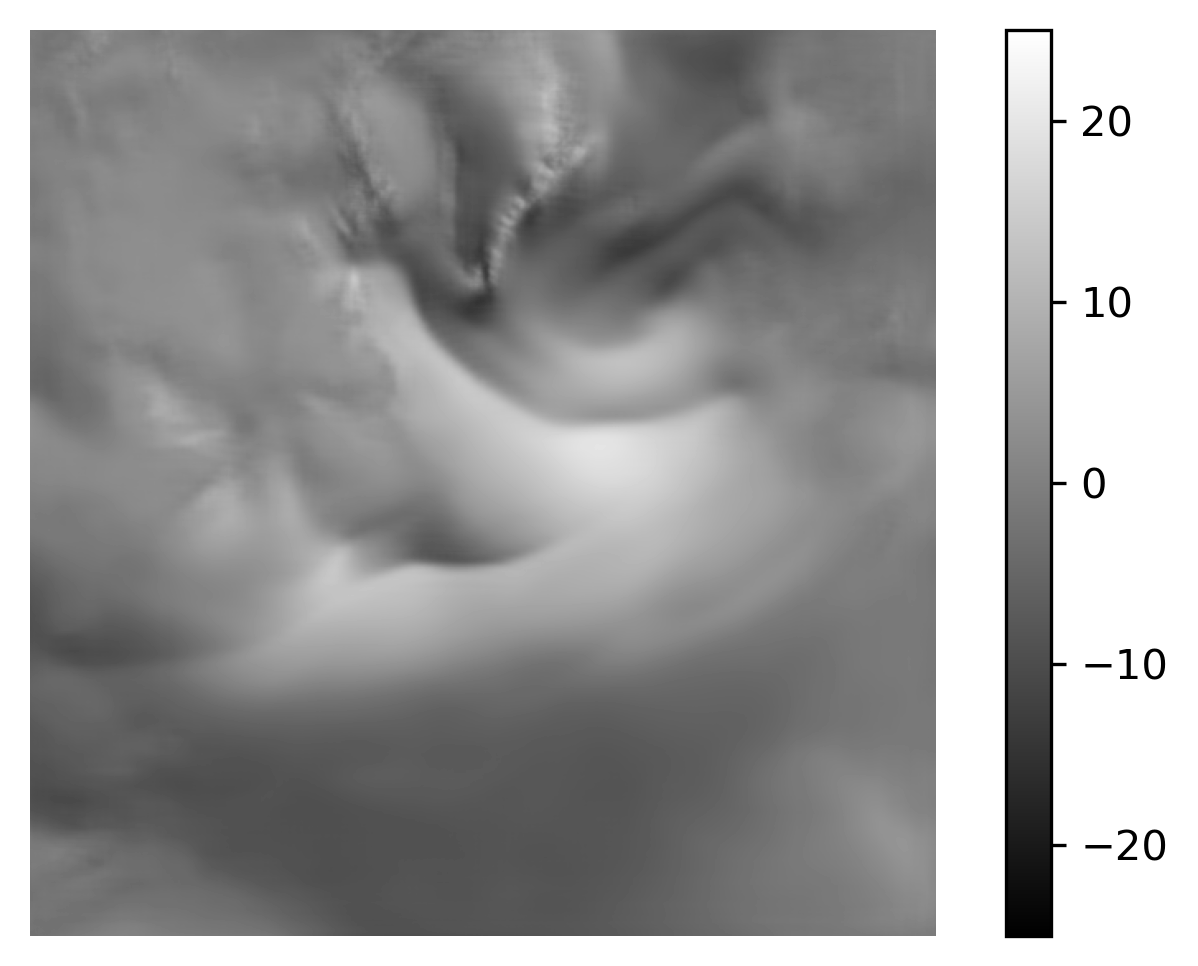

In [45]:
_ = plt.imshow(u_nn.cpu().detach().numpy(), cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

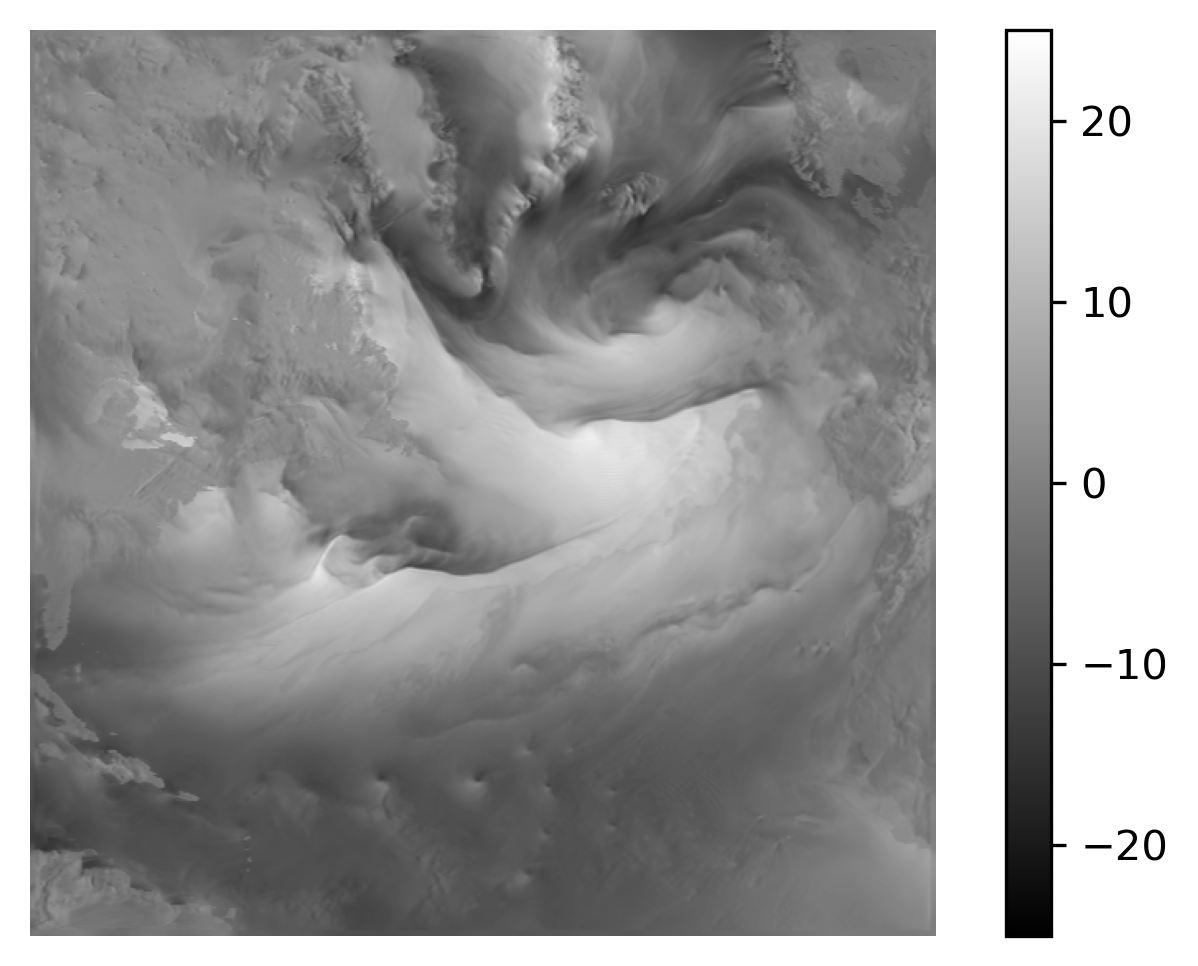

In [46]:
_ = plt.imshow(u_hr[0], cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

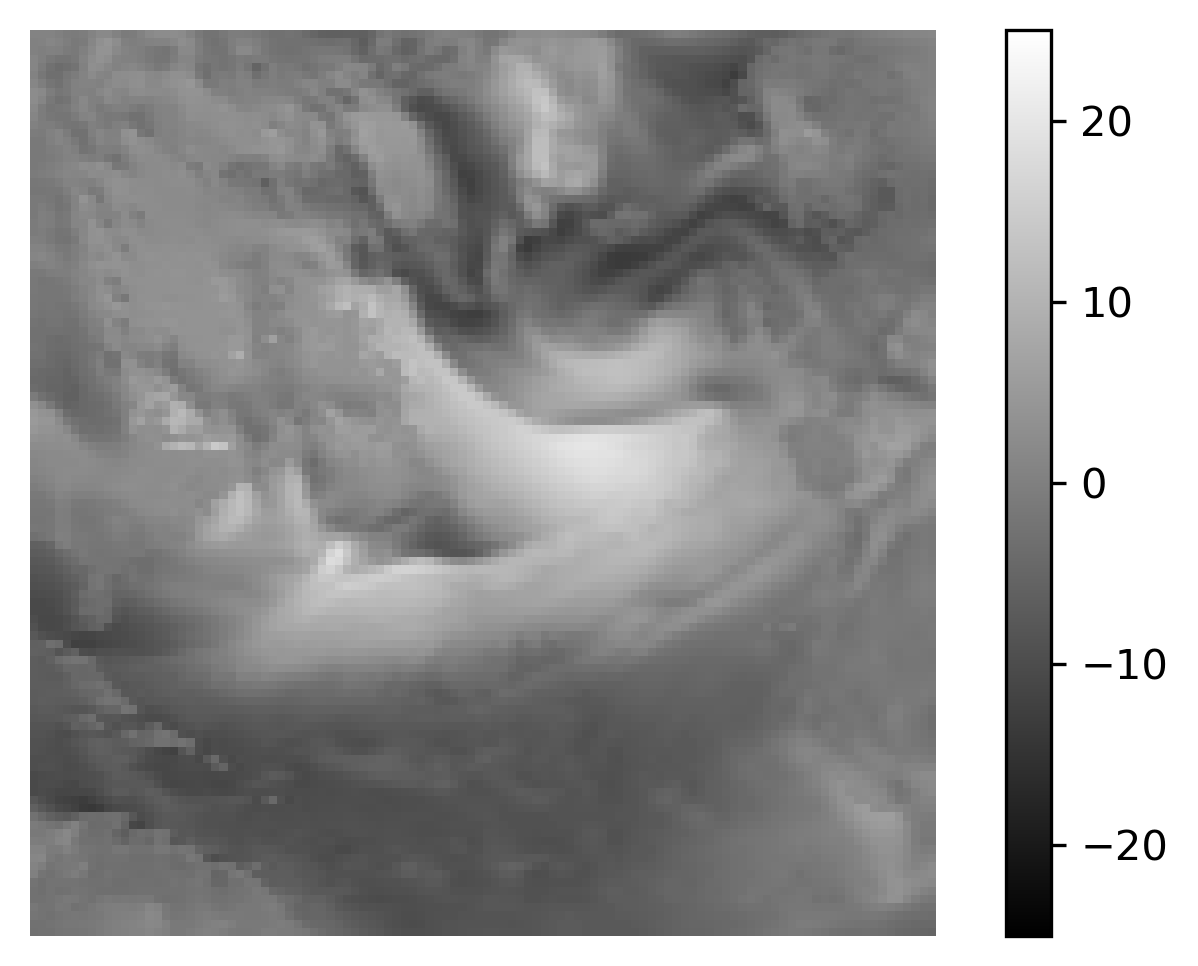

In [47]:
_ = plt.imshow(field_lr[0][0], cmap = 'gray', vmin = -25, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')

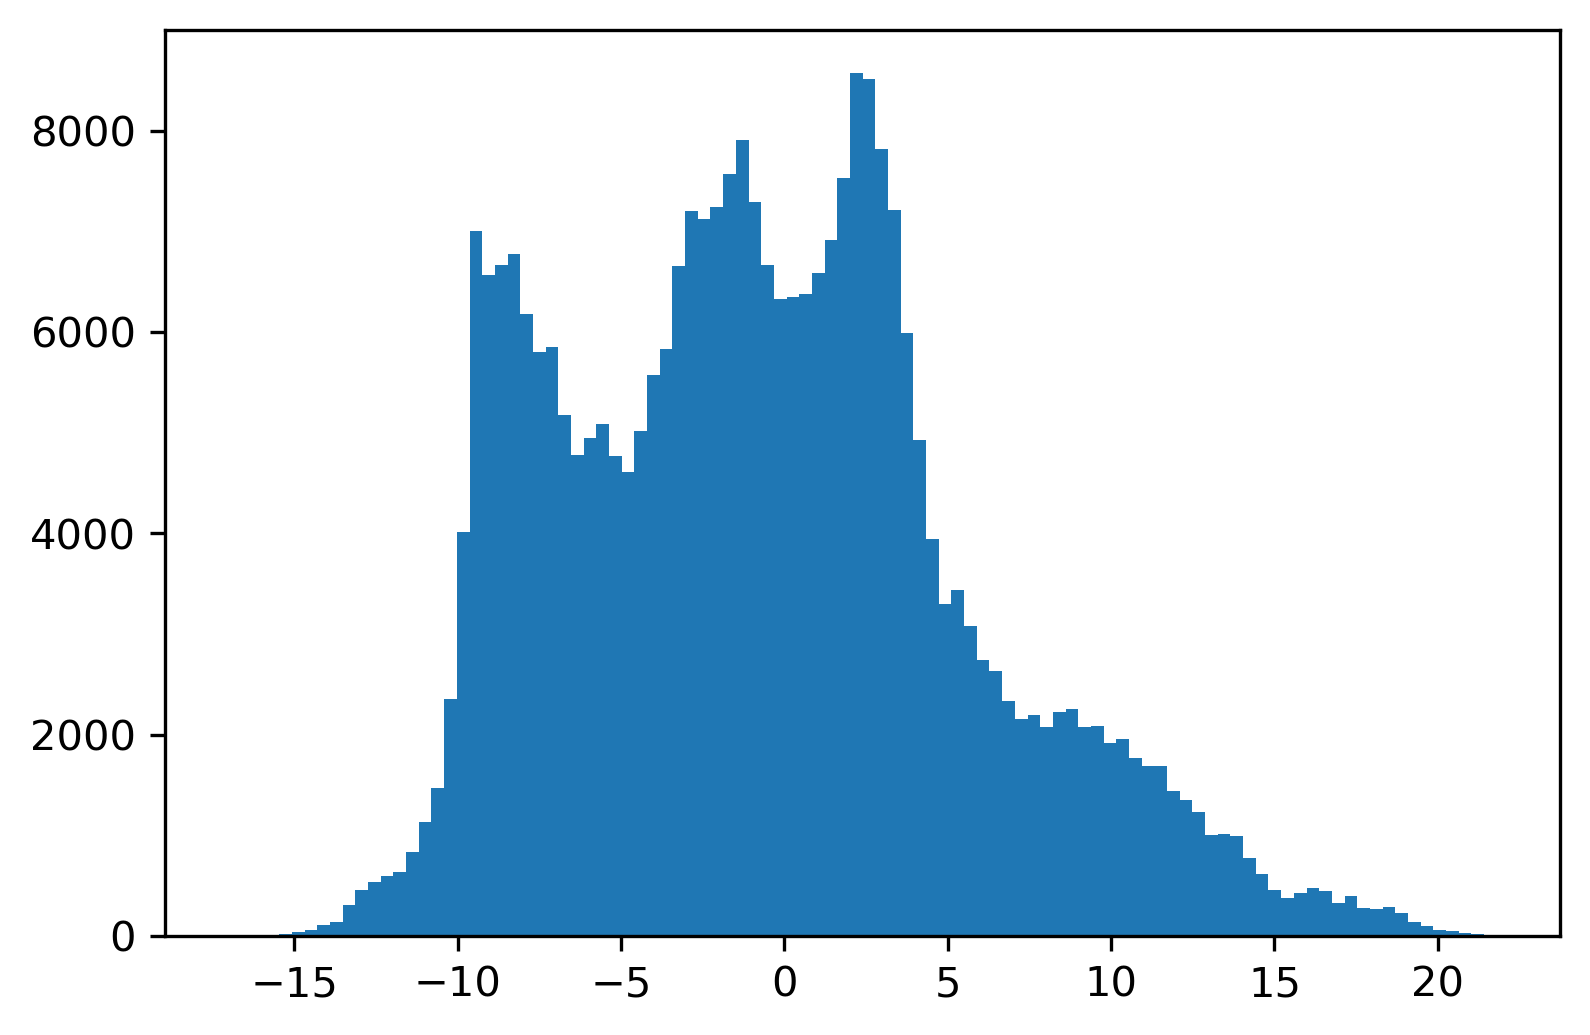

In [48]:
_ = plt.hist(u_hr[0].flatten(), bins = 100)
_ = plt.savefig("High.png")

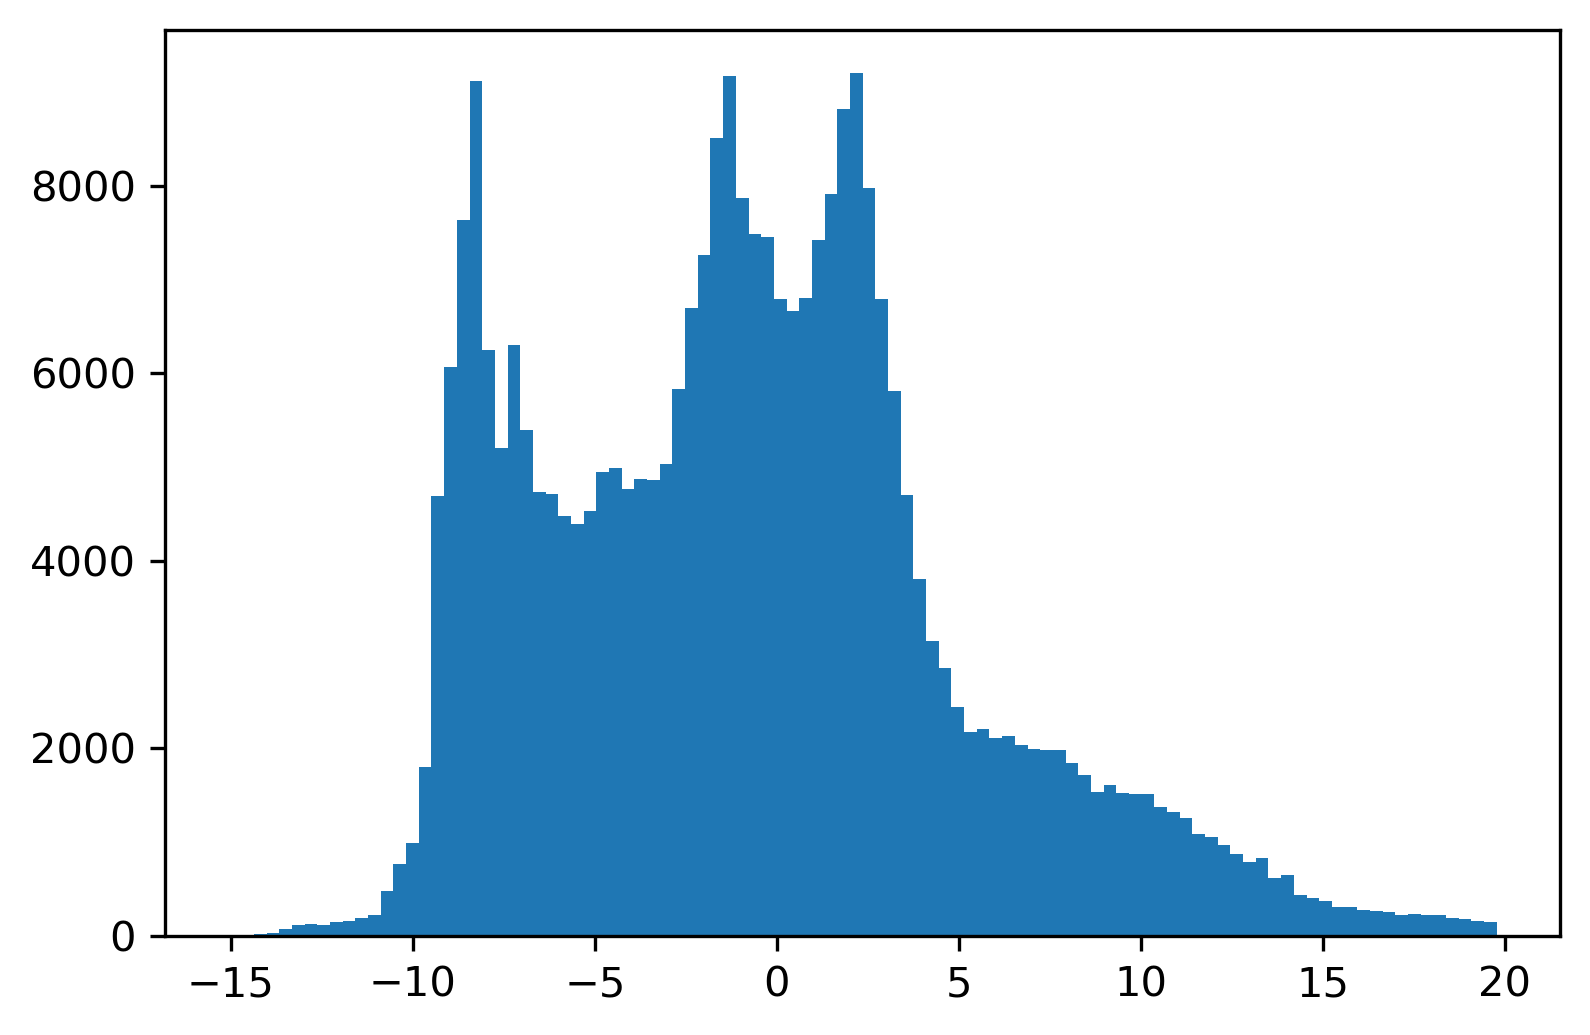

In [49]:
_ = plt.hist(u_nn.cpu().detach().numpy().flatten(), bins = 100)
_ = plt.savefig("NN.png")

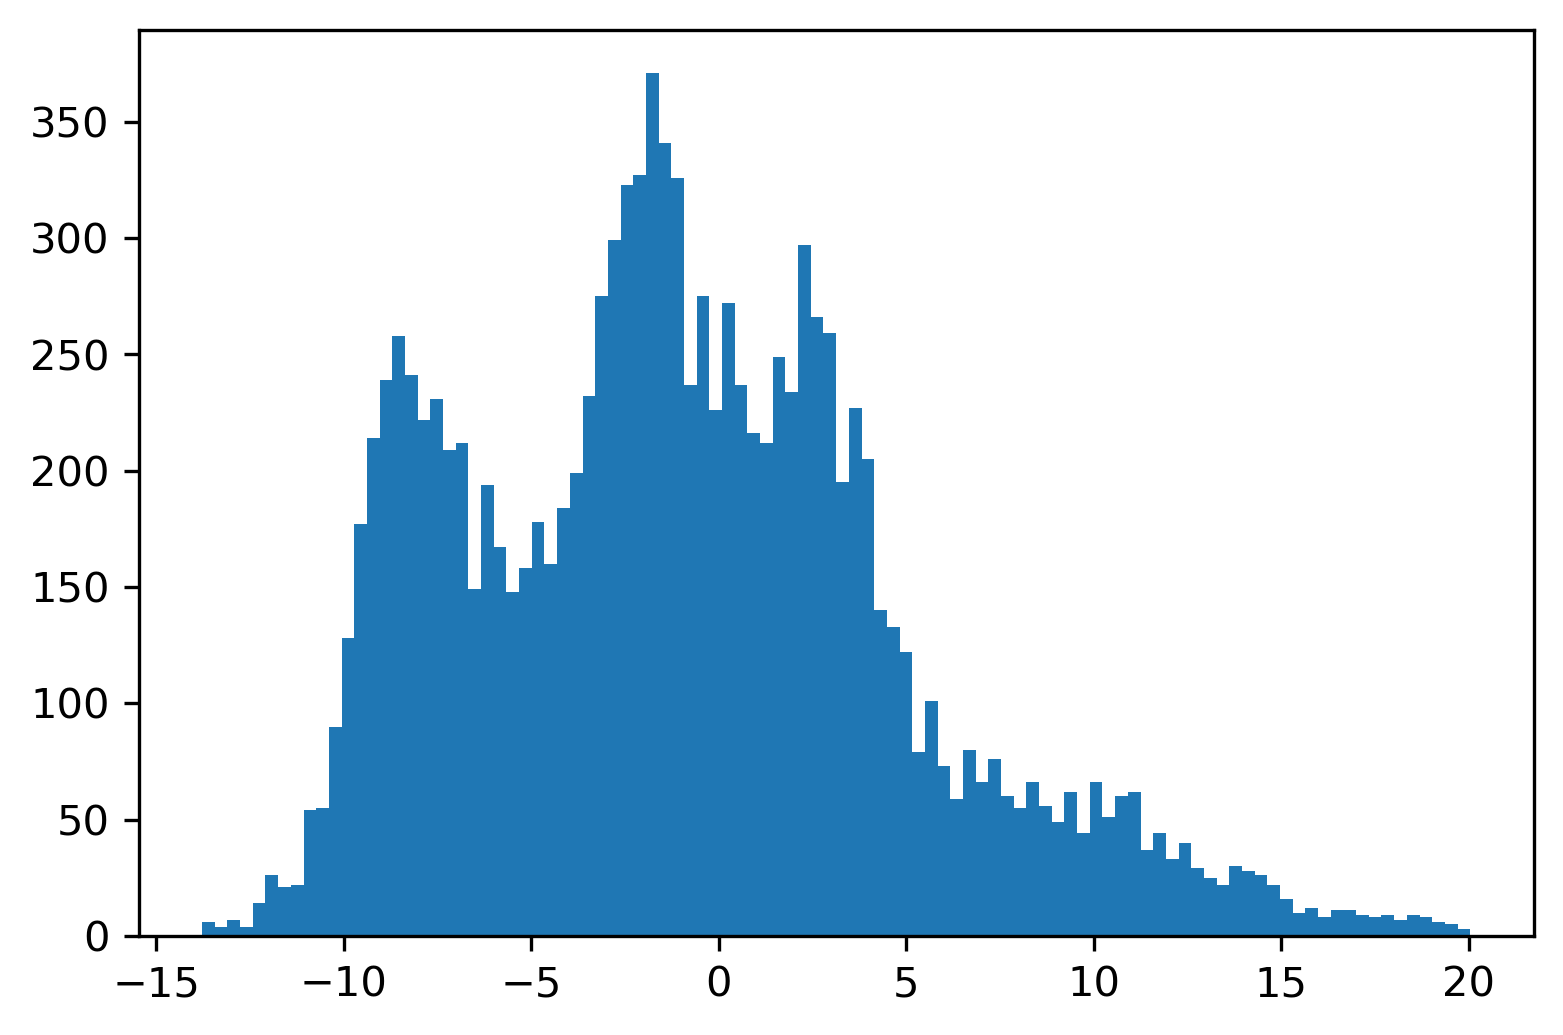

In [50]:
_ = plt.hist(field_lr[0][0].flatten(), bins = 100)
_ = plt.savefig("Low.png")